In [1]:
!pip install kagglehub kaggle
!kaggle datasets download -d undefinenull/million-song-dataset-spotify-lastfm
!unzip million-song-dataset-spotify-lastfm.zip

Dataset URL: https://www.kaggle.com/datasets/undefinenull/million-song-dataset-spotify-lastfm
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 639M/639M [00:03<00:00, 263MB/s]
100% 639M/639M [00:03<00:00, 217MB/s]
Archive:  million-song-dataset-spotify-lastfm.zip
  inflating: MP3-Example/Blues/Blues-TRACOHF128F1498509.mp3  
  inflating: MP3-Example/Blues/Blues-TRADWSG128F4259317.mp3  
  inflating: MP3-Example/Blues/Blues-TRAELUY128F93147BA.mp3  
  inflating: MP3-Example/Blues/Blues-TRAHVWB128F9308FB0.mp3  
  inflating: MP3-Example/Blues/Blues-TRAJGIO128F92E84BC.mp3  
  inflating: MP3-Example/Blues/Blues-TRAOPNA128F427E83F.mp3  
  inflating: MP3-Example/Blues/Blues-TRAQGFP128E078FAB6.mp3  
  inflating: MP3-Example/Blues/Blues-TRARJEK128F930B3AA.mp3  
  inflating: MP3-Example/Blues/Blues-TRATLTV128F92FC979.mp3  
  inflating: MP3-Example/Blues/Blues-TRAUJPR128F92CA3AF.mp3  
  inflating: MP3-Example/Blues/Blues-TRAUYOD128F42647FE.mp3  
  inflating: MP3-Example/Bl

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
df = pd.read_csv('User Listening History.csv')

In [ ]:
# df = pd.read_csv("/kaggle/input/million-song-dataset-spotify-lastfm/User Listening History.csv")

In [4]:
df

,track_id,user_id,playcount
0,TRIRLYL128F42539D1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
1,TRFUPBA128F934F7E1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
2,TRLQPQJ128F42AA94F,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
3,TRTUCUY128F92E1D24,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
4,TRHDDQG12903CB53EE,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
...,...,...,...
9711296,TRBKFKL128E078ED76,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,1
9711297,TRYFXPG128E078ECBD,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,1
9711298,TROBUUZ128F4263002,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,1
9711299,TROEWXC128F148C83E,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,1


In [5]:
def stats(df):
  num_users = df['user_id'].nunique()
  print("total # of users : ",num_users)

  # Count the appearances of each user
  user_counts = df['user_id'].value_counts()

  # Find the user with the maximum appearances
  max_user = user_counts.idxmax()
  max_count = user_counts.max()

  # Find the user with the minimum appearances
  min_user = user_counts.idxmin()
  min_count = user_counts.min()

  print(f"User with maximum appearances: {max_user} ({max_count} times)")
  print(f"User with minimum appearances: {min_user} ({min_count} times)")

  # Calculate the average number of interactions per user
  average_interactions = user_counts.mean()

  print(f"Average number of interactions per user: {average_interactions:.2f}")

In [6]:
stats(df)

total # of users :  962037
User with maximum appearances: ec6dfcf19485cb011e0b22637075037aae34cf26 (784 times)
User with minimum appearances: 6f62f1c30b0f4b87db28c101ddcab89b4f5d7298 (1 times)
Average number of interactions per user: 10.09


Theres no much interaction density

In [7]:
# Count the number of interactions per user
user_interaction_counts = df['user_id'].value_counts()

# Filter out users with only 50 interaction
users_with_high_interactions = user_interaction_counts[user_interaction_counts > 50].index

# Filter the original DataFrame to keep only users with more than 50 interaction
filtered_df = df[df['user_id'].isin(users_with_high_interactions)]

In [8]:
stats(filtered_df)

total # of users :  22733
User with maximum appearances: ec6dfcf19485cb011e0b22637075037aae34cf26 (784 times)
User with minimum appearances: 8305c896f42308824da7d4386f4b9ee584281412 (51 times)
Average number of interactions per user: 77.20


In [9]:
# Function to get the last `n_interactions`, excluding the latest `exclude_count`
def get_last_n_excluding_latest(group, n, exclude_count):
    if len(group) > n + exclude_count:
        # Skip the latest `exclude_count` interactions, then get the next `n` interactions
        return group.iloc[-(n + exclude_count):-exclude_count]
    elif len(group) > exclude_count:
        # If there are fewer than `n + exclude_count` but more than `exclude_count` interactions, return all after skipping the latest `exclude_count`
        return group.iloc[:-exclude_count]
    else:
        # If there are fewer than `exclude_count` interactions, return all available interactions
        return group


In [10]:
# Function to get the last `n_interactions`
def get_last_n(df, n=10):
    aggregated_df = df.groupby(['user_id', 'track_id'], as_index=False)['playcount'].sum()

    aggregated_df = aggregated_df.sort_values(['user_id', 'playcount'], ascending=[True, False])

    top_n_tracks = aggregated_df.groupby('user_id').head(n).reset_index(drop=True)

    return top_n_tracks[['user_id', 'track_id', 'playcount']]

In [11]:
test_set = filtered_df.groupby('user_id', group_keys=False).apply(lambda x: get_last_n(x, 10)).reset_index(drop=True)

<ipython-input-11-aa75ccd57687>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_set = filtered_df.groupby('user_id', group_keys=False).apply(lambda x: get_last_n(x, 10)).reset_index(drop=True)


This test set contains latest 10 interactions of each user

In [12]:
test_set = test_set.drop(columns=['playcount'])

In [13]:
test_set

,user_id,track_id
0,0003a64f7a69e5b87a80b09c3772227185c235c7,TRTBNOP12903CDB267
1,0003a64f7a69e5b87a80b09c3772227185c235c7,TRBMCGS128F92D2C27
2,0003a64f7a69e5b87a80b09c3772227185c235c7,TRNPEXS128F1460294
3,0003a64f7a69e5b87a80b09c3772227185c235c7,TRRSBHA128F425E8B5
4,0003a64f7a69e5b87a80b09c3772227185c235c7,TRFMQJK128F9321BCC
...,...,...
227325,ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5,TRBVNWT128F93173BA
227326,ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5,TRCDGSB128F429EA6C
227327,ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5,TRGAQVK12903D08292
227328,ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5,TRWRUCY128F424351B


In [14]:
# Apply the function to each user group and reset the index
last_n_excluding_latest = filtered_df.groupby('user_id', group_keys=False).apply(lambda x: get_last_n_excluding_latest(x, 200,10)).reset_index(drop=True)

print(last_n_excluding_latest.shape)

(1520397, 3)


<ipython-input-14-fe3d5776ad01>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_n_excluding_latest = filtered_df.groupby('user_id', group_keys=False).apply(lambda x: get_last_n_excluding_latest(x, 200,10)).reset_index(drop=True)


Now, this dataset contains, only the latest 200 interactions(without latest 10) of every user who had at least 50 interactions

In [16]:
aggregated_data = last_n_excluding_latest.groupby(['user_id', 'track_id'], as_index=False).agg({'playcount': 'mean'})

In [63]:
unique_track_id_count = aggregated_data['track_id'].nunique()
print(f"Unique track_id count: {unique_track_id_count}")


Unique track_id count: 26481


In [17]:
aggregated_data['playcount'].unique()

array([2.000e+00, 1.000e+00, 5.000e+00, 3.000e+00, 4.000e+00, 6.000e+00,
       1.200e+01, 1.000e+01, 7.000e+00, 9.000e+00, 1.700e+01, 1.100e+01,
       8.000e+00, 1.400e+01, 1.600e+01, 1.800e+01, 1.300e+01, 3.000e+01,
       1.900e+01, 1.500e+01, 2.000e+01, 4.300e+01, 4.800e+01, 3.200e+01,
       2.500e+01, 2.400e+01, 2.300e+01, 3.100e+01, 2.800e+01, 2.200e+01,
       6.200e+01, 2.700e+01, 1.090e+02, 4.500e+01, 3.900e+01, 3.500e+01,
       3.400e+01, 3.600e+01, 2.100e+01, 2.900e+01, 3.300e+01, 2.810e+02,
       4.900e+01, 3.700e+01, 3.800e+01, 4.700e+01, 4.100e+01, 4.600e+01,
       5.700e+01, 2.600e+01, 5.300e+01, 1.830e+02, 5.000e+01, 7.200e+01,
       6.300e+01, 7.000e+01, 7.800e+01, 9.000e+01, 8.600e+01, 6.000e+01,
       4.000e+01, 7.900e+01, 6.600e+01, 9.100e+01, 8.100e+01, 7.600e+01,
       6.900e+01, 4.200e+01, 5.500e+01, 7.300e+01, 7.700e+01, 5.100e+01,
       1.560e+02, 5.200e+01, 6.700e+01, 5.900e+01, 5.400e+01, 7.500e+01,
       1.760e+02, 6.800e+01, 6.100e+01, 5.800e+01, 

In [18]:
aggregated_data

,user_id,track_id,playcount
0,0003a64f7a69e5b87a80b09c3772227185c235c7,TRAFUNV128F92CFEB2,2.0
1,0003a64f7a69e5b87a80b09c3772227185c235c7,TRAKKTI128F42B4F25,1.0
2,0003a64f7a69e5b87a80b09c3772227185c235c7,TRARTEH128F423DBC1,1.0
3,0003a64f7a69e5b87a80b09c3772227185c235c7,TRAVRKY128F429EA68,1.0
4,0003a64f7a69e5b87a80b09c3772227185c235c7,TRBFKOV128F426DDF1,1.0
...,...,...,...
1723295,ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5,TRYDVHI128F93268D6,1.0
1723296,ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5,TRYHSFE128F429EA71,1.0
1723297,ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5,TRYIKBI128F426FFF2,2.0
1723298,ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5,TRZALGW128F4296174,1.0


This contains the latest average interaction of each user for each song

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Convert playcounts to ratings
def convert_to_rating(playcount):
    if playcount >= 10:
        return 5
    elif playcount >= 5:
        return 4
    elif playcount >= 2:
        return 3
    elif playcount >= 1:
        return 2
    else:
        return 0 #this wont be used

aggregated_data['rating'] = aggregated_data['playcount'].apply(convert_to_rating)

In [20]:
aggregated_data

,user_id,track_id,playcount,rating
0,0003a64f7a69e5b87a80b09c3772227185c235c7,TRAFUNV128F92CFEB2,2.0,3
1,0003a64f7a69e5b87a80b09c3772227185c235c7,TRAKKTI128F42B4F25,1.0,2
2,0003a64f7a69e5b87a80b09c3772227185c235c7,TRARTEH128F423DBC1,1.0,2
3,0003a64f7a69e5b87a80b09c3772227185c235c7,TRAVRKY128F429EA68,1.0,2
4,0003a64f7a69e5b87a80b09c3772227185c235c7,TRBFKOV128F426DDF1,1.0,2
...,...,...,...,...
1723295,ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5,TRYDVHI128F93268D6,1.0,2
1723296,ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5,TRYHSFE128F429EA71,1.0,2
1723297,ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5,TRYIKBI128F426FFF2,2.0,3
1723298,ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5,TRZALGW128F4296174,1.0,2


In [21]:
aggregated_data.describe()

,playcount,rating
count,1.723300e+06,1.723300e+06
mean,2.113467e+00,2.472647e+00
std,3.409747e+00,7.214924e-01
min,1.000000e+00,2.000000e+00
25%,1.000000e+00,2.000000e+00
50%,1.000000e+00,2.000000e+00
75%,2.000000e+00,3.000000e+00
max,1.134000e+03,5.000000e+00


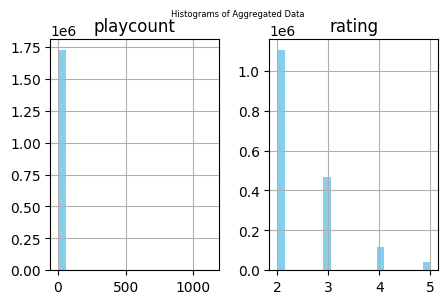

In [22]:
# Plotting histograms for each column
aggregated_data.hist(bins=20, figsize=(5, 3), color='skyblue')
plt.suptitle("Histograms of Aggregated Data", fontsize=6)
plt.show()

In [23]:

#  Create the user-item matrix as a sparse matrix
user_item_matrix_sparse = csr_matrix(pd.pivot_table(
    aggregated_data, index='user_id', columns='track_id', values='rating').fillna(0).values)

# print(user_item_matrix_sparse)

#  Save the sparse matrix to disk using pickle
with open('user_item_matrix_sparse.pkl', 'wb') as f:
    pickle.dump(user_item_matrix_sparse, f)

# Load the sparse matrix from disk
# with open('user_item_matrix_sparse.pkl', 'rb') as f:
#     user_item_matrix_sparse = pickle.load(f)



## Cosine Similarity

In [24]:
#  Compute cosine similarity between users using sparse matrix
user_similarity = cosine_similarity(user_item_matrix_sparse)

# Convert the similarity matrix to a DataFrame for easier manipulation
user_similarity_df = pd.DataFrame(user_similarity)

In [25]:
user_similarity_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,22723,22724,22725,22726,22727,22728,22729,22730,22731,22732
0,1.000000,0.000000,0.062838,0.000000,0.037561,0.080532,0.000000,0.000000,0.008430,0.015847,...,0.014212,0.000000,0.000000,0.000000,0.000000,0.023435,0.017702,0.000000,0.000000,0.090688
1,0.000000,1.000000,0.009637,0.011831,0.000000,0.070491,0.014118,0.011036,0.016808,0.039493,...,0.018890,0.000000,0.000000,0.031953,0.047324,0.000000,0.011765,0.028739,0.000000,0.013393
2,0.062838,0.009637,1.000000,0.000000,0.037764,0.000000,0.000000,0.000000,0.068458,0.036767,...,0.010991,0.045852,0.289263,0.020658,0.041303,0.021749,0.000000,0.006370,0.008263,0.010391
3,0.000000,0.011831,0.000000,1.000000,0.000000,0.000000,0.164045,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011205,0.007820,0.055792,0.000000
4,0.037561,0.000000,0.037764,0.000000,1.000000,0.014165,0.003405,0.013306,0.043908,0.000000,...,0.017082,0.017815,0.000000,0.006421,0.000000,0.014084,0.039008,0.048263,0.006421,0.020186
5,0.080532,0.070491,0.000000,0.000000,0.014165,1.000000,0.000000,0.010437,0.021195,0.041501,...,0.029776,0.000000,0.011020,0.000000,0.128674,0.023568,0.051924,0.000000,0.000000,0.069668
6,0.000000,0.014118,0.000000,0.164045,0.003405,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.004294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003733,0.007263,0.000000
7,0.000000,0.011036,0.000000,0.000000,0.013306,0.010437,0.000000,1.000000,0.052261,0.000000,...,0.050345,0.000000,0.000000,0.000000,0.021021,0.033207,0.041806,0.000000,0.018924,0.011898
8,0.008430,0.016808,0.068458,0.000000,0.043908,0.021195,0.000000,0.052261,1.000000,0.033249,...,0.054313,0.059463,0.072257,0.028823,0.032015,0.095884,0.149896,0.016665,0.007206,0.046815
9,0.015847,0.039493,0.036767,0.000000,0.000000,0.041501,0.000000,0.000000,0.033249,1.000000,...,0.032030,0.082869,0.079026,0.009030,0.000000,0.114877,0.000000,0.000000,0.000000,0.017032


In [26]:
#Create an index map from the user_id to numerical indices
user_index_map = {user_id: idx for idx, user_id in enumerate(aggregated_data['user_id'].unique())}

In [27]:
user_ids_list = aggregated_data['user_id'].unique().tolist()

In [28]:
def get_top_n_tracks(df, n):
    """
    Function to get the top n tracks with the highest playcounts.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the track data.
    n (int): The number of top tracks to return.

    Returns:
    pandas.DataFrame: A DataFrame containing the top n tracks and their total playcounts.
    """
    # Group by track_id and sum the playcounts
    track_playcounts = df.groupby('track_id')['playcount'].sum()

    # Sort by playcount in descending order and get the top n
    top_n_tracks = track_playcounts.sort_values(ascending=False).head(n)

    # Convert to DataFrame and reset index
    top_n_tracks_df = top_n_tracks.reset_index()

    # Rename columns for clarity
    top_n_tracks_df.columns = ['track_id', 'total_playcount']

    return top_n_tracks_df

In [29]:
import random
# Update the get_recommendations function to use indices
def get_recommendations(user_id, n_recommendations=10):
    # Map user_id to the corresponding index
    user_idx = user_index_map.get(user_id, None)

    #already_listened_songs = aggregated_data[aggregated_data['user_id'] == similar_user_id]

    if user_idx is None:
        #print(f"User ID {user_id} not found.")
        return []

    similar_users = user_similarity_df.iloc[user_idx].sort_values(ascending=False)[1:]  # Exclude the user itself
    top_similar_users = similar_users.index[:n_recommendations-2]

    len_sim = len(top_similar_users)
    #print(len_sim)
    if len_sim>7:
        n=1
    elif len_sim>3:
        n=2
    elif len_sim>2:
        n=3
    else:
        n=len_sim

    recommendations = set()
    listened_songs = aggregated_data[aggregated_data['user_id'] == user_id]  # get the already listened songs
    fav_songs = get_top_n_tracks(listened_songs, 2 )
    #print(fav_songs)
    recommendations.update(set(fav_songs['track_id'].tolist()))

    rec_set_len=len(recommendations)

    for similar_user in top_similar_users:
        similar_user_id = aggregated_data['user_id'].unique()[similar_user]  # Get the actual user ID
        similar_user_songs = aggregated_data[aggregated_data['user_id'] == similar_user_id]  # get the songs of each user
        similar_user_song = get_top_n_tracks(similar_user_songs, n )
        recommended_songs = similar_user_song['track_id'].tolist()

        #print(recommended_songs)
        recommendations.update(set(recommended_songs))
        k=n
        while (len(recommendations)<(rec_set_len+ n)):
            #print(recommendations)
            #print("len",len(recommendations), rec_set_len, len(recommended_songs))
            k+=1
            similar_user_song = get_top_n_tracks(similar_user_songs, k )
            recommended_songs = similar_user_song['track_id'].tolist()
            #print("trying for k =",k, "tried id =", recommended_songs)
            recommendations.update(set(recommended_songs))

            if len(recommendations)>=10: #infinite loop breaker
                break

        rec_set_len = len(recommendations)
        #print(rec_set_len)

    if len(recommendations)>10:
        return random.sample(list(recommendations), 10)

    return list(recommendations)

In [30]:
#  Get recommendations for a specific user
user_id = aggregated_data['user_id'].iloc[10]  # Replace with actual user ID
recommendations = get_recommendations(user_id)
print(f"Recommendations for user {user_id}: {recommendations}")

Recommendations for user 0003a64f7a69e5b87a80b09c3772227185c235c7: ['TRAFUNV128F92CFEB2', 'TRTBNOP12903CDB267', 'TRJSTNN128F92E16AE', 'TRLKBRU128F42B18A3', 'TRRXFHO128EF3550BC', 'TRHLTZE128F92E16C7', 'TRNPEXS128F1460294', 'TRBVSQT128F427A82F', 'TRAVRKY128F429EA68', 'TRHGDIO128F9324EF2']


# Evaluating

In [31]:
test_set.head(5)

,user_id,track_id
0,0003a64f7a69e5b87a80b09c3772227185c235c7,TRTBNOP12903CDB267
1,0003a64f7a69e5b87a80b09c3772227185c235c7,TRBMCGS128F92D2C27
2,0003a64f7a69e5b87a80b09c3772227185c235c7,TRNPEXS128F1460294
3,0003a64f7a69e5b87a80b09c3772227185c235c7,TRRSBHA128F425E8B5
4,0003a64f7a69e5b87a80b09c3772227185c235c7,TRFMQJK128F9321BCC


In [32]:
# Specify the user_id you want to filter for
specific_user_id = '0003a64f7a69e5b87a80b09c3772227185c235c7'

# Filter test_set for the specific user and get the track_id column as a list
track_ids = test_set[test_set['user_id'] == specific_user_id]['track_id'].tolist()

# Output the list of track_ids
print(track_ids)


['TRTBNOP12903CDB267', 'TRBMCGS128F92D2C27', 'TRNPEXS128F1460294', 'TRRSBHA128F425E8B5', 'TRFMQJK128F9321BCC', 'TRBROBA128F9321BC2', 'TRAFUNV128F92CFEB2', 'TRDPRSH128F9321BC6', 'TRAKKTI128F42B4F25', 'TRARTEH128F423DBC1']


In [33]:
recommendations = get_recommendations(specific_user_id)
print(recommendations)

['TRAFUNV128F92CFEB2', 'TRTBNOP12903CDB267', 'TRJSTNN128F92E16AE', 'TRLKBRU128F42B18A3', 'TRRXFHO128EF3550BC', 'TRHLTZE128F92E16C7', 'TRNPEXS128F1460294', 'TRBVSQT128F427A82F', 'TRAVRKY128F429EA68', 'TRHGDIO128F9324EF2']


In [34]:
def calculate_hit_percentage(evaluating_list, recommended_list):
    # Convert lists to sets to find the intersection
    evaluating_set = set(evaluating_list)
    recommended_set = set(recommended_list)

    # Find the intersection (hits) between the two sets
    hits = evaluating_set.intersection(recommended_set)

    # Calculate hit percentage
    hit_percentage = (len(hits) / len(evaluating_list)) * 100 if evaluating_list else 0
    return hit_percentage


In [35]:
hit_percentage = calculate_hit_percentage(track_ids, recommendations)
print(f"Hit Percentage: {hit_percentage}%")

Hit Percentage: 30.0%


In [36]:
!pip install tqdm

In [37]:
def select_random_items(data_list, percentage):
    # Calculate the number of items to select
    num_items_to_select = max(1, int(len(data_list) * percentage / 100))

    # Use random.sample to select the specified percentage of items
    selected_items = random.sample(data_list, num_items_to_select)

    return selected_items

In [38]:
from tqdm import tqdm

def calculate_average_hit_percentage(user_ids_list, test_set_df):
    total_hit_percentage = 0
    individual_hit_percentages = []

    print("\nStarting Hit Percentage Calculation...\n")

    # Loop through each user_id to calculate the hit percentage with a progress bar
    for user_id in tqdm(user_ids_list, desc="Calculating Hit Percentages", unit="user"):
        # Get the list of recommended tracks for the current user
        recommended_list = get_recommendations(user_id)

        # Get actual track_ids for the current user
        user_tracks = test_set_df[test_set_df['user_id'] == user_id]['track_id'].tolist()

        # Calculate hit percentage for this user
        user_hit_percentage = calculate_hit_percentage(user_tracks, recommended_list)
        individual_hit_percentages.append(user_hit_percentage)

        # Add to the total hit percentage
        total_hit_percentage += user_hit_percentage

        # Update progress bar with cumulative average hit percentage
        cumulative_average = total_hit_percentage / len(individual_hit_percentages)
        tqdm.write(f"Current Average Hit Percentage: {cumulative_average:.2f}%")

    # Calculate the average hit percentage across all users
    average_hit_percentage = total_hit_percentage / len(user_ids_list) if user_ids_list else 0

    # Final Summary
    print("\nCalculation Complete!")
    print(f"Total Users Processed: {len(user_ids_list)}")
    print(f"Average Hit Percentage: {average_hit_percentage:.2f}%\n")

    return average_hit_percentage, individual_hit_percentages

#randmly select 5% of users for testing
selected_items = select_random_items(user_ids_list, 5)
# Run the function
average_hit_percentage, individual_hit_percentages = calculate_average_hit_percentage(selected_items, test_set)



Starting Hit Percentage Calculation...



Calculating Hit Percentages:   0%|          | 1/1136 [00:02<40:13,  2.13s/user]

Current Average Hit Percentage: 50.00%


Calculating Hit Percentages:   0%|          | 2/1136 [00:04<39:29,  2.09s/user]

Current Average Hit Percentage: 35.00%


Calculating Hit Percentages:   0%|          | 3/1136 [00:06<39:01,  2.07s/user]

Current Average Hit Percentage: 40.00%


Calculating Hit Percentages:   0%|          | 4/1136 [00:08<38:46,  2.06s/user]

Current Average Hit Percentage: 35.00%


Calculating Hit Percentages:   0%|          | 5/1136 [00:10<38:37,  2.05s/user]

Current Average Hit Percentage: 34.00%


Calculating Hit Percentages:   1%|          | 6/1136 [00:12<38:38,  2.05s/user]

Current Average Hit Percentage: 33.33%


Calculating Hit Percentages:   1%|          | 7/1136 [00:14<39:00,  2.07s/user]

Current Average Hit Percentage: 31.43%


Calculating Hit Percentages:   1%|          | 8/1136 [00:16<38:49,  2.07s/user]

Current Average Hit Percentage: 31.25%


Calculating Hit Percentages:   1%|          | 9/1136 [00:18<38:41,  2.06s/user]

Current Average Hit Percentage: 32.22%


Calculating Hit Percentages:   1%|          | 10/1136 [00:20<38:34,  2.06s/user]

Current Average Hit Percentage: 34.00%


Calculating Hit Percentages:   1%|          | 11/1136 [00:22<38:28,  2.05s/user]

Current Average Hit Percentage: 32.73%


Calculating Hit Percentages:   1%|          | 12/1136 [00:24<38:22,  2.05s/user]

Current Average Hit Percentage: 33.33%


Calculating Hit Percentages:   1%|          | 13/1136 [00:26<38:19,  2.05s/user]

Current Average Hit Percentage: 33.08%


Calculating Hit Percentages:   1%|          | 14/1136 [00:28<38:39,  2.07s/user]

Current Average Hit Percentage: 33.57%


Calculating Hit Percentages:   1%|▏         | 15/1136 [00:30<38:27,  2.06s/user]

Current Average Hit Percentage: 33.33%


Calculating Hit Percentages:   1%|▏         | 16/1136 [00:32<38:18,  2.05s/user]

Current Average Hit Percentage: 33.12%


Calculating Hit Percentages:   1%|▏         | 17/1136 [00:34<38:09,  2.05s/user]

Current Average Hit Percentage: 32.94%


Calculating Hit Percentages:   2%|▏         | 18/1136 [00:37<38:09,  2.05s/user]

Current Average Hit Percentage: 32.78%


Calculating Hit Percentages:   2%|▏         | 19/1136 [00:39<38:05,  2.05s/user]

Current Average Hit Percentage: 32.11%


Calculating Hit Percentages:   2%|▏         | 20/1136 [00:41<38:11,  2.05s/user]

Current Average Hit Percentage: 31.50%


Calculating Hit Percentages:   2%|▏         | 21/1136 [00:43<38:14,  2.06s/user]

Current Average Hit Percentage: 30.95%


Calculating Hit Percentages:   2%|▏         | 22/1136 [00:45<38:10,  2.06s/user]

Current Average Hit Percentage: 31.36%


Calculating Hit Percentages:   2%|▏         | 23/1136 [00:47<37:59,  2.05s/user]

Current Average Hit Percentage: 30.87%


Calculating Hit Percentages:   2%|▏         | 24/1136 [00:49<37:53,  2.04s/user]

Current Average Hit Percentage: 31.67%


Calculating Hit Percentages:   2%|▏         | 25/1136 [00:51<37:52,  2.05s/user]

Current Average Hit Percentage: 31.60%


Calculating Hit Percentages:   2%|▏         | 26/1136 [00:53<37:52,  2.05s/user]

Current Average Hit Percentage: 31.54%


Calculating Hit Percentages:   2%|▏         | 27/1136 [00:55<38:06,  2.06s/user]

Current Average Hit Percentage: 31.48%


Calculating Hit Percentages:   2%|▏         | 28/1136 [00:57<38:14,  2.07s/user]

Current Average Hit Percentage: 32.50%


Calculating Hit Percentages:   3%|▎         | 29/1136 [00:59<38:05,  2.06s/user]

Current Average Hit Percentage: 32.41%


Calculating Hit Percentages:   3%|▎         | 30/1136 [01:01<37:56,  2.06s/user]

Current Average Hit Percentage: 32.00%


Calculating Hit Percentages:   3%|▎         | 31/1136 [01:03<37:52,  2.06s/user]

Current Average Hit Percentage: 31.61%


Calculating Hit Percentages:   3%|▎         | 32/1136 [01:05<37:42,  2.05s/user]

Current Average Hit Percentage: 31.56%


Calculating Hit Percentages:   3%|▎         | 33/1136 [01:07<37:42,  2.05s/user]

Current Average Hit Percentage: 31.21%


Calculating Hit Percentages:   3%|▎         | 34/1136 [01:09<37:54,  2.06s/user]

Current Average Hit Percentage: 31.18%


Calculating Hit Percentages:   3%|▎         | 35/1136 [01:11<37:49,  2.06s/user]

Current Average Hit Percentage: 31.14%


Calculating Hit Percentages:   3%|▎         | 36/1136 [01:14<37:42,  2.06s/user]

Current Average Hit Percentage: 30.83%


Calculating Hit Percentages:   3%|▎         | 37/1136 [01:16<37:32,  2.05s/user]

Current Average Hit Percentage: 30.81%


Calculating Hit Percentages:   3%|▎         | 38/1136 [01:18<37:24,  2.04s/user]

Current Average Hit Percentage: 30.53%


Calculating Hit Percentages:   3%|▎         | 39/1136 [01:20<37:22,  2.04s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:   4%|▎         | 40/1136 [01:22<37:28,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:   4%|▎         | 41/1136 [01:24<37:38,  2.06s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:   4%|▎         | 42/1136 [01:26<37:25,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:   4%|▍         | 43/1136 [01:28<37:18,  2.05s/user]

Current Average Hit Percentage: 30.23%


Calculating Hit Percentages:   4%|▍         | 44/1136 [01:30<37:09,  2.04s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:   4%|▍         | 45/1136 [01:32<37:05,  2.04s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:   4%|▍         | 46/1136 [01:34<37:02,  2.04s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:   4%|▍         | 47/1136 [01:36<37:18,  2.06s/user]

Current Average Hit Percentage: 29.79%


Calculating Hit Percentages:   4%|▍         | 48/1136 [01:38<37:13,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:   4%|▍         | 49/1136 [01:40<37:07,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:   4%|▍         | 50/1136 [01:42<37:01,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:   4%|▍         | 51/1136 [01:44<36:56,  2.04s/user]

Current Average Hit Percentage: 29.80%


Calculating Hit Percentages:   5%|▍         | 52/1136 [01:46<36:52,  2.04s/user]

Current Average Hit Percentage: 29.62%


Calculating Hit Percentages:   5%|▍         | 53/1136 [01:48<36:49,  2.04s/user]

Current Average Hit Percentage: 29.81%


Calculating Hit Percentages:   5%|▍         | 54/1136 [01:50<37:14,  2.06s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:   5%|▍         | 55/1136 [01:53<37:18,  2.07s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:   5%|▍         | 56/1136 [01:55<37:14,  2.07s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:   5%|▌         | 57/1136 [01:57<37:03,  2.06s/user]

Current Average Hit Percentage: 30.70%


Calculating Hit Percentages:   5%|▌         | 58/1136 [01:59<36:53,  2.05s/user]

Current Average Hit Percentage: 30.69%


Calculating Hit Percentages:   5%|▌         | 59/1136 [02:01<36:50,  2.05s/user]

Current Average Hit Percentage: 31.02%


Calculating Hit Percentages:   5%|▌         | 60/1136 [02:03<36:49,  2.05s/user]

Current Average Hit Percentage: 31.17%


Calculating Hit Percentages:   5%|▌         | 61/1136 [02:05<36:53,  2.06s/user]

Current Average Hit Percentage: 31.15%


Calculating Hit Percentages:   5%|▌         | 62/1136 [02:07<36:51,  2.06s/user]

Current Average Hit Percentage: 30.97%


Calculating Hit Percentages:   6%|▌         | 63/1136 [02:09<36:45,  2.06s/user]

Current Average Hit Percentage: 31.11%


Calculating Hit Percentages:   6%|▌         | 64/1136 [02:11<36:41,  2.05s/user]

Current Average Hit Percentage: 31.09%


Calculating Hit Percentages:   6%|▌         | 65/1136 [02:13<36:35,  2.05s/user]

Current Average Hit Percentage: 30.92%


Calculating Hit Percentages:   6%|▌         | 66/1136 [02:15<36:31,  2.05s/user]

Current Average Hit Percentage: 30.76%


Calculating Hit Percentages:   6%|▌         | 67/1136 [02:17<36:33,  2.05s/user]

Current Average Hit Percentage: 30.60%


Calculating Hit Percentages:   6%|▌         | 68/1136 [02:19<36:41,  2.06s/user]

Current Average Hit Percentage: 30.44%


Calculating Hit Percentages:   6%|▌         | 69/1136 [02:21<36:39,  2.06s/user]

Current Average Hit Percentage: 30.43%


Calculating Hit Percentages:   6%|▌         | 70/1136 [02:23<36:31,  2.06s/user]

Current Average Hit Percentage: 30.43%


Calculating Hit Percentages:   6%|▋         | 71/1136 [02:25<36:20,  2.05s/user]

Current Average Hit Percentage: 30.42%


Calculating Hit Percentages:   6%|▋         | 72/1136 [02:27<36:14,  2.04s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:   6%|▋         | 73/1136 [02:29<36:10,  2.04s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:   7%|▋         | 74/1136 [02:32<36:24,  2.06s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:   7%|▋         | 75/1136 [02:34<36:26,  2.06s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:   7%|▋         | 76/1136 [02:36<36:15,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:   7%|▋         | 77/1136 [02:38<36:11,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:   7%|▋         | 78/1136 [02:40<36:08,  2.05s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:   7%|▋         | 79/1136 [02:42<36:00,  2.04s/user]

Current Average Hit Percentage: 30.38%


Calculating Hit Percentages:   7%|▋         | 80/1136 [02:44<35:59,  2.04s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:   7%|▋         | 81/1136 [02:46<36:17,  2.06s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:   7%|▋         | 82/1136 [02:48<36:11,  2.06s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:   7%|▋         | 83/1136 [02:50<35:58,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:   7%|▋         | 84/1136 [02:52<35:55,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:   7%|▋         | 85/1136 [02:54<35:49,  2.04s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:   8%|▊         | 86/1136 [02:56<35:48,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:   8%|▊         | 87/1136 [02:58<35:49,  2.05s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:   8%|▊         | 88/1136 [03:00<36:03,  2.06s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:   8%|▊         | 89/1136 [03:02<35:57,  2.06s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:   8%|▊         | 90/1136 [03:04<35:49,  2.06s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:   8%|▊         | 91/1136 [03:06<35:45,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:   8%|▊         | 92/1136 [03:08<35:39,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:   8%|▊         | 93/1136 [03:10<35:31,  2.04s/user]

Current Average Hit Percentage: 30.43%


Calculating Hit Percentages:   8%|▊         | 94/1136 [03:13<35:42,  2.06s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:   8%|▊         | 95/1136 [03:15<35:40,  2.06s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:   8%|▊         | 96/1136 [03:17<35:36,  2.05s/user]

Current Average Hit Percentage: 30.31%


Calculating Hit Percentages:   9%|▊         | 97/1136 [03:19<35:26,  2.05s/user]

Current Average Hit Percentage: 30.21%


Calculating Hit Percentages:   9%|▊         | 98/1136 [03:21<35:30,  2.05s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:   9%|▊         | 99/1136 [03:23<35:26,  2.05s/user]

Current Average Hit Percentage: 30.20%


Calculating Hit Percentages:   9%|▉         | 100/1136 [03:25<35:19,  2.05s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:   9%|▉         | 101/1136 [03:27<35:29,  2.06s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:   9%|▉         | 102/1136 [03:29<35:30,  2.06s/user]

Current Average Hit Percentage: 30.20%


Calculating Hit Percentages:   9%|▉         | 103/1136 [03:31<35:22,  2.05s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:   9%|▉         | 104/1136 [03:33<35:20,  2.06s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:   9%|▉         | 105/1136 [03:35<35:12,  2.05s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:   9%|▉         | 106/1136 [03:37<35:12,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:   9%|▉         | 107/1136 [03:39<35:11,  2.05s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  10%|▉         | 108/1136 [03:41<35:23,  2.07s/user]

Current Average Hit Percentage: 30.09%


Calculating Hit Percentages:  10%|▉         | 109/1136 [03:43<35:16,  2.06s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  10%|▉         | 110/1136 [03:45<35:08,  2.06s/user]

Current Average Hit Percentage: 30.09%


Calculating Hit Percentages:  10%|▉         | 111/1136 [03:47<35:01,  2.05s/user]

Current Average Hit Percentage: 30.27%


Calculating Hit Percentages:  10%|▉         | 112/1136 [03:49<34:51,  2.04s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  10%|▉         | 113/1136 [03:52<34:49,  2.04s/user]

Current Average Hit Percentage: 30.27%


Calculating Hit Percentages:  10%|█         | 114/1136 [03:54<35:01,  2.06s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  10%|█         | 115/1136 [03:56<35:05,  2.06s/user]

Current Average Hit Percentage: 30.09%


Calculating Hit Percentages:  10%|█         | 116/1136 [03:58<35:02,  2.06s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:  10%|█         | 117/1136 [04:00<34:52,  2.05s/user]

Current Average Hit Percentage: 30.17%


Calculating Hit Percentages:  10%|█         | 118/1136 [04:02<34:48,  2.05s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  10%|█         | 119/1136 [04:04<34:41,  2.05s/user]

Current Average Hit Percentage: 30.42%


Calculating Hit Percentages:  11%|█         | 120/1136 [04:06<34:37,  2.04s/user]

Current Average Hit Percentage: 30.50%


Calculating Hit Percentages:  11%|█         | 121/1136 [04:08<34:47,  2.06s/user]

Current Average Hit Percentage: 30.50%


Calculating Hit Percentages:  11%|█         | 122/1136 [04:10<34:48,  2.06s/user]

Current Average Hit Percentage: 30.41%


Calculating Hit Percentages:  11%|█         | 123/1136 [04:12<34:40,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  11%|█         | 124/1136 [04:14<34:31,  2.05s/user]

Current Average Hit Percentage: 30.24%


Calculating Hit Percentages:  11%|█         | 125/1136 [04:16<34:28,  2.05s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  11%|█         | 126/1136 [04:18<34:21,  2.04s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  11%|█         | 127/1136 [04:20<34:25,  2.05s/user]

Current Average Hit Percentage: 30.31%


Calculating Hit Percentages:  11%|█▏        | 128/1136 [04:22<34:39,  2.06s/user]

Current Average Hit Percentage: 30.31%


Calculating Hit Percentages:  11%|█▏        | 129/1136 [04:24<34:35,  2.06s/user]

Current Average Hit Percentage: 30.23%


Calculating Hit Percentages:  11%|█▏        | 130/1136 [04:26<34:26,  2.05s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  12%|█▏        | 131/1136 [04:28<34:18,  2.05s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  12%|█▏        | 132/1136 [04:31<34:11,  2.04s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  12%|█▏        | 133/1136 [04:33<34:09,  2.04s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  12%|█▏        | 134/1136 [04:35<34:10,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  12%|█▏        | 135/1136 [04:37<34:22,  2.06s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  12%|█▏        | 136/1136 [04:39<34:16,  2.06s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  12%|█▏        | 137/1136 [04:41<34:09,  2.05s/user]

Current Average Hit Percentage: 30.07%


Calculating Hit Percentages:  12%|█▏        | 138/1136 [04:43<34:07,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  12%|█▏        | 139/1136 [04:45<33:58,  2.04s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  12%|█▏        | 140/1136 [04:47<33:54,  2.04s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  12%|█▏        | 141/1136 [04:49<33:59,  2.05s/user]

Current Average Hit Percentage: 29.86%


Calculating Hit Percentages:  12%|█▎        | 142/1136 [04:51<34:10,  2.06s/user]

Current Average Hit Percentage: 29.79%


Calculating Hit Percentages:  13%|█▎        | 143/1136 [04:53<34:02,  2.06s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  13%|█▎        | 144/1136 [04:55<33:55,  2.05s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  13%|█▎        | 145/1136 [04:57<33:52,  2.05s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  13%|█▎        | 146/1136 [04:59<33:47,  2.05s/user]

Current Average Hit Percentage: 29.86%


Calculating Hit Percentages:  13%|█▎        | 147/1136 [05:01<33:46,  2.05s/user]

Current Average Hit Percentage: 29.86%


Calculating Hit Percentages:  13%|█▎        | 148/1136 [05:03<34:06,  2.07s/user]

Current Average Hit Percentage: 29.86%


Calculating Hit Percentages:  13%|█▎        | 149/1136 [05:05<34:02,  2.07s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  13%|█▎        | 150/1136 [05:08<33:54,  2.06s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  13%|█▎        | 151/1136 [05:10<33:45,  2.06s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  13%|█▎        | 152/1136 [05:12<33:38,  2.05s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:  13%|█▎        | 153/1136 [05:14<33:34,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  14%|█▎        | 154/1136 [05:16<33:36,  2.05s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  14%|█▎        | 155/1136 [05:18<33:42,  2.06s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:  14%|█▎        | 156/1136 [05:20<33:36,  2.06s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:  14%|█▍        | 157/1136 [05:22<33:31,  2.05s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  14%|█▍        | 158/1136 [05:24<33:24,  2.05s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  14%|█▍        | 159/1136 [05:26<33:16,  2.04s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  14%|█▍        | 160/1136 [05:28<33:13,  2.04s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  14%|█▍        | 161/1136 [05:30<33:23,  2.06s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  14%|█▍        | 162/1136 [05:32<33:29,  2.06s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  14%|█▍        | 163/1136 [05:34<33:21,  2.06s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  14%|█▍        | 164/1136 [05:36<33:12,  2.05s/user]

Current Average Hit Percentage: 30.24%


Calculating Hit Percentages:  15%|█▍        | 165/1136 [05:38<33:08,  2.05s/user]

Current Average Hit Percentage: 30.24%


Calculating Hit Percentages:  15%|█▍        | 166/1136 [05:40<33:03,  2.04s/user]

Current Average Hit Percentage: 30.24%


Calculating Hit Percentages:  15%|█▍        | 167/1136 [05:42<33:00,  2.04s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  15%|█▍        | 168/1136 [05:44<33:10,  2.06s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  15%|█▍        | 169/1136 [05:47<33:07,  2.06s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  15%|█▍        | 170/1136 [05:49<33:02,  2.05s/user]

Current Average Hit Percentage: 30.35%


Calculating Hit Percentages:  15%|█▌        | 171/1136 [05:51<32:56,  2.05s/user]

Current Average Hit Percentage: 30.35%


Calculating Hit Percentages:  15%|█▌        | 172/1136 [05:53<32:52,  2.05s/user]

Current Average Hit Percentage: 30.35%


Calculating Hit Percentages:  15%|█▌        | 173/1136 [05:55<32:49,  2.04s/user]

Current Average Hit Percentage: 30.35%


Calculating Hit Percentages:  15%|█▌        | 174/1136 [05:57<32:47,  2.05s/user]

Current Average Hit Percentage: 30.29%


Calculating Hit Percentages:  15%|█▌        | 175/1136 [05:59<33:00,  2.06s/user]

Current Average Hit Percentage: 30.40%


Calculating Hit Percentages:  15%|█▌        | 176/1136 [06:01<32:54,  2.06s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  16%|█▌        | 177/1136 [06:03<32:53,  2.06s/user]

Current Average Hit Percentage: 30.40%


Calculating Hit Percentages:  16%|█▌        | 178/1136 [06:05<32:46,  2.05s/user]

Current Average Hit Percentage: 30.39%


Calculating Hit Percentages:  16%|█▌        | 179/1136 [06:07<32:42,  2.05s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  16%|█▌        | 180/1136 [06:09<32:37,  2.05s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:  16%|█▌        | 181/1136 [06:11<32:39,  2.05s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  16%|█▌        | 182/1136 [06:13<32:48,  2.06s/user]

Current Average Hit Percentage: 30.27%


Calculating Hit Percentages:  16%|█▌        | 183/1136 [06:15<32:40,  2.06s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  16%|█▌        | 184/1136 [06:17<32:32,  2.05s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  16%|█▋        | 185/1136 [06:19<32:26,  2.05s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  16%|█▋        | 186/1136 [06:21<32:30,  2.05s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  16%|█▋        | 187/1136 [06:23<32:23,  2.05s/user]

Current Average Hit Percentage: 30.21%


Calculating Hit Percentages:  17%|█▋        | 188/1136 [06:26<32:28,  2.06s/user]

Current Average Hit Percentage: 30.21%


Calculating Hit Percentages:  17%|█▋        | 189/1136 [06:28<32:34,  2.06s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:  17%|█▋        | 190/1136 [06:30<32:24,  2.06s/user]

Current Average Hit Percentage: 30.21%


Calculating Hit Percentages:  17%|█▋        | 191/1136 [06:32<32:18,  2.05s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:  17%|█▋        | 192/1136 [06:34<32:15,  2.05s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:  17%|█▋        | 193/1136 [06:36<32:11,  2.05s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:  17%|█▋        | 194/1136 [06:38<32:11,  2.05s/user]

Current Average Hit Percentage: 30.21%


Calculating Hit Percentages:  17%|█▋        | 195/1136 [06:40<32:16,  2.06s/user]

Current Average Hit Percentage: 30.21%


Calculating Hit Percentages:  17%|█▋        | 196/1136 [06:42<32:16,  2.06s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:  17%|█▋        | 197/1136 [06:44<32:07,  2.05s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  17%|█▋        | 198/1136 [06:46<31:59,  2.05s/user]

Current Average Hit Percentage: 30.20%


Calculating Hit Percentages:  18%|█▊        | 199/1136 [06:48<31:54,  2.04s/user]

Current Average Hit Percentage: 30.30%


Calculating Hit Percentages:  18%|█▊        | 200/1136 [06:50<31:47,  2.04s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  18%|█▊        | 201/1136 [06:52<31:49,  2.04s/user]

Current Average Hit Percentage: 30.20%


Calculating Hit Percentages:  18%|█▊        | 202/1136 [06:54<32:05,  2.06s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  18%|█▊        | 203/1136 [06:56<31:58,  2.06s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  18%|█▊        | 204/1136 [06:58<31:54,  2.05s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  18%|█▊        | 205/1136 [07:00<31:45,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  18%|█▊        | 206/1136 [07:02<31:42,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  18%|█▊        | 207/1136 [07:04<31:39,  2.05s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  18%|█▊        | 208/1136 [07:07<31:47,  2.06s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  18%|█▊        | 209/1136 [07:09<31:53,  2.06s/user]

Current Average Hit Percentage: 30.24%


Calculating Hit Percentages:  18%|█▊        | 210/1136 [07:11<31:44,  2.06s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  19%|█▊        | 211/1136 [07:13<31:38,  2.05s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  19%|█▊        | 212/1136 [07:15<31:30,  2.05s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  19%|█▉        | 213/1136 [07:17<31:25,  2.04s/user]

Current Average Hit Percentage: 30.23%


Calculating Hit Percentages:  19%|█▉        | 214/1136 [07:19<31:20,  2.04s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  19%|█▉        | 215/1136 [07:21<31:27,  2.05s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  19%|█▉        | 216/1136 [07:23<31:29,  2.05s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  19%|█▉        | 217/1136 [07:25<31:23,  2.05s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  19%|█▉        | 218/1136 [07:27<31:18,  2.05s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  19%|█▉        | 219/1136 [07:29<31:14,  2.04s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  19%|█▉        | 220/1136 [07:31<31:09,  2.04s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  19%|█▉        | 221/1136 [07:33<31:12,  2.05s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  20%|█▉        | 222/1136 [07:35<31:27,  2.07s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  20%|█▉        | 223/1136 [07:37<31:21,  2.06s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  20%|█▉        | 224/1136 [07:39<31:13,  2.05s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  20%|█▉        | 225/1136 [07:41<31:08,  2.05s/user]

Current Average Hit Percentage: 30.31%


Calculating Hit Percentages:  20%|█▉        | 226/1136 [07:43<31:04,  2.05s/user]

Current Average Hit Percentage: 30.27%


Calculating Hit Percentages:  20%|█▉        | 227/1136 [07:45<30:58,  2.04s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:  20%|██        | 228/1136 [07:48<31:04,  2.05s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  20%|██        | 229/1136 [07:50<31:10,  2.06s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  20%|██        | 230/1136 [07:52<31:05,  2.06s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  20%|██        | 231/1136 [07:54<31:01,  2.06s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  20%|██        | 232/1136 [07:56<30:56,  2.05s/user]

Current Average Hit Percentage: 30.17%


Calculating Hit Percentages:  21%|██        | 233/1136 [07:58<30:47,  2.05s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  21%|██        | 234/1136 [08:00<30:42,  2.04s/user]

Current Average Hit Percentage: 30.09%


Calculating Hit Percentages:  21%|██        | 235/1136 [08:02<30:54,  2.06s/user]

Current Average Hit Percentage: 30.09%


Calculating Hit Percentages:  21%|██        | 236/1136 [08:04<30:55,  2.06s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  21%|██        | 237/1136 [08:06<30:48,  2.06s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  21%|██        | 238/1136 [08:08<30:41,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  21%|██        | 239/1136 [08:10<30:35,  2.05s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  21%|██        | 240/1136 [08:12<30:33,  2.05s/user]

Current Average Hit Percentage: 30.29%


Calculating Hit Percentages:  21%|██        | 241/1136 [08:14<30:32,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  21%|██▏       | 242/1136 [08:16<30:41,  2.06s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  21%|██▏       | 243/1136 [08:18<30:41,  2.06s/user]

Current Average Hit Percentage: 30.37%


Calculating Hit Percentages:  21%|██▏       | 244/1136 [08:20<30:36,  2.06s/user]

Current Average Hit Percentage: 30.37%


Calculating Hit Percentages:  22%|██▏       | 245/1136 [08:22<30:34,  2.06s/user]

Current Average Hit Percentage: 30.37%


Calculating Hit Percentages:  22%|██▏       | 246/1136 [08:25<30:25,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  22%|██▏       | 247/1136 [08:27<30:19,  2.05s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  22%|██▏       | 248/1136 [08:29<30:19,  2.05s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  22%|██▏       | 249/1136 [08:31<30:29,  2.06s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  22%|██▏       | 250/1136 [08:33<30:34,  2.07s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  22%|██▏       | 251/1136 [08:35<30:25,  2.06s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:  22%|██▏       | 252/1136 [08:37<30:23,  2.06s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  22%|██▏       | 253/1136 [08:39<30:16,  2.06s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  22%|██▏       | 254/1136 [08:41<30:10,  2.05s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:  22%|██▏       | 255/1136 [08:43<30:19,  2.07s/user]

Current Average Hit Percentage: 30.27%


Calculating Hit Percentages:  23%|██▎       | 256/1136 [08:45<30:22,  2.07s/user]

Current Average Hit Percentage: 30.27%


Calculating Hit Percentages:  23%|██▎       | 257/1136 [08:47<30:17,  2.07s/user]

Current Average Hit Percentage: 30.23%


Calculating Hit Percentages:  23%|██▎       | 258/1136 [08:49<30:08,  2.06s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  23%|██▎       | 259/1136 [08:51<30:09,  2.06s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  23%|██▎       | 260/1136 [08:53<30:05,  2.06s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  23%|██▎       | 261/1136 [08:55<30:08,  2.07s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  23%|██▎       | 262/1136 [08:58<30:24,  2.09s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  23%|██▎       | 263/1136 [09:00<30:16,  2.08s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  23%|██▎       | 264/1136 [09:02<30:09,  2.07s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  23%|██▎       | 265/1136 [09:04<30:03,  2.07s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  23%|██▎       | 266/1136 [09:06<30:00,  2.07s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  24%|██▎       | 267/1136 [09:08<29:54,  2.07s/user]

Current Average Hit Percentage: 30.07%


Calculating Hit Percentages:  24%|██▎       | 268/1136 [09:10<29:56,  2.07s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  24%|██▎       | 269/1136 [09:12<30:19,  2.10s/user]

Current Average Hit Percentage: 30.07%


Calculating Hit Percentages:  24%|██▍       | 270/1136 [09:14<30:09,  2.09s/user]

Current Average Hit Percentage: 30.07%


Calculating Hit Percentages:  24%|██▍       | 271/1136 [09:16<29:54,  2.07s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  24%|██▍       | 272/1136 [09:18<29:44,  2.07s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  24%|██▍       | 273/1136 [09:20<29:35,  2.06s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  24%|██▍       | 274/1136 [09:22<29:29,  2.05s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  24%|██▍       | 275/1136 [09:24<29:34,  2.06s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  24%|██▍       | 276/1136 [09:27<29:31,  2.06s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  24%|██▍       | 277/1136 [09:29<29:25,  2.06s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  24%|██▍       | 278/1136 [09:31<29:20,  2.05s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  25%|██▍       | 279/1136 [09:33<29:18,  2.05s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  25%|██▍       | 280/1136 [09:35<29:12,  2.05s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  25%|██▍       | 281/1136 [09:37<29:14,  2.05s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  25%|██▍       | 282/1136 [09:39<29:27,  2.07s/user]

Current Average Hit Percentage: 30.39%


Calculating Hit Percentages:  25%|██▍       | 283/1136 [09:41<29:28,  2.07s/user]

Current Average Hit Percentage: 30.39%


Calculating Hit Percentages:  25%|██▌       | 284/1136 [09:43<29:20,  2.07s/user]

Current Average Hit Percentage: 30.39%


Calculating Hit Percentages:  25%|██▌       | 285/1136 [09:45<29:12,  2.06s/user]

Current Average Hit Percentage: 30.35%


Calculating Hit Percentages:  25%|██▌       | 286/1136 [09:47<29:08,  2.06s/user]

Current Average Hit Percentage: 30.31%


Calculating Hit Percentages:  25%|██▌       | 287/1136 [09:49<29:02,  2.05s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:  25%|██▌       | 288/1136 [09:51<29:03,  2.06s/user]

Current Average Hit Percentage: 30.31%


Calculating Hit Percentages:  25%|██▌       | 289/1136 [09:53<29:27,  2.09s/user]

Current Average Hit Percentage: 30.31%


Calculating Hit Percentages:  26%|██▌       | 290/1136 [09:55<29:23,  2.08s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:  26%|██▌       | 291/1136 [09:58<29:13,  2.08s/user]

Current Average Hit Percentage: 30.24%


Calculating Hit Percentages:  26%|██▌       | 292/1136 [10:00<29:04,  2.07s/user]

Current Average Hit Percentage: 30.21%


Calculating Hit Percentages:  26%|██▌       | 293/1136 [10:02<28:55,  2.06s/user]

Current Average Hit Percentage: 30.24%


Calculating Hit Percentages:  26%|██▌       | 294/1136 [10:04<28:48,  2.05s/user]

Current Average Hit Percentage: 30.20%


Calculating Hit Percentages:  26%|██▌       | 295/1136 [10:06<28:56,  2.07s/user]

Current Average Hit Percentage: 30.20%


Calculating Hit Percentages:  26%|██▌       | 296/1136 [10:08<28:59,  2.07s/user]

Current Average Hit Percentage: 30.24%


Calculating Hit Percentages:  26%|██▌       | 297/1136 [10:10<28:51,  2.06s/user]

Current Average Hit Percentage: 30.27%


Calculating Hit Percentages:  26%|██▌       | 298/1136 [10:12<28:43,  2.06s/user]

Current Average Hit Percentage: 30.27%


Calculating Hit Percentages:  26%|██▋       | 299/1136 [10:14<28:39,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  26%|██▋       | 300/1136 [10:16<28:32,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  26%|██▋       | 301/1136 [10:18<28:27,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  27%|██▋       | 302/1136 [10:20<28:33,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  27%|██▋       | 303/1136 [10:22<28:35,  2.06s/user]

Current Average Hit Percentage: 30.30%


Calculating Hit Percentages:  27%|██▋       | 304/1136 [10:24<28:29,  2.05s/user]

Current Average Hit Percentage: 30.23%


Calculating Hit Percentages:  27%|██▋       | 305/1136 [10:26<28:20,  2.05s/user]

Current Average Hit Percentage: 30.20%


Calculating Hit Percentages:  27%|██▋       | 306/1136 [10:28<28:17,  2.05s/user]

Current Average Hit Percentage: 30.20%


Calculating Hit Percentages:  27%|██▋       | 307/1136 [10:30<28:11,  2.04s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:  27%|██▋       | 308/1136 [10:32<28:12,  2.04s/user]

Current Average Hit Percentage: 30.23%


Calculating Hit Percentages:  27%|██▋       | 309/1136 [10:34<28:23,  2.06s/user]

Current Average Hit Percentage: 30.23%


Calculating Hit Percentages:  27%|██▋       | 310/1136 [10:37<28:18,  2.06s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  27%|██▋       | 311/1136 [10:39<28:14,  2.05s/user]

Current Average Hit Percentage: 30.23%


Calculating Hit Percentages:  27%|██▋       | 312/1136 [10:41<28:08,  2.05s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  28%|██▊       | 313/1136 [10:43<28:04,  2.05s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  28%|██▊       | 314/1136 [10:45<28:03,  2.05s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  28%|██▊       | 315/1136 [10:47<28:00,  2.05s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  28%|██▊       | 316/1136 [10:49<28:06,  2.06s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  28%|██▊       | 317/1136 [10:51<28:01,  2.05s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  28%|██▊       | 318/1136 [10:53<27:59,  2.05s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  28%|██▊       | 319/1136 [10:55<27:57,  2.05s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  28%|██▊       | 320/1136 [10:57<27:53,  2.05s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  28%|██▊       | 321/1136 [10:59<27:47,  2.05s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  28%|██▊       | 322/1136 [11:01<27:57,  2.06s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  28%|██▊       | 323/1136 [11:03<28:03,  2.07s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  29%|██▊       | 324/1136 [11:05<27:55,  2.06s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  29%|██▊       | 325/1136 [11:07<27:47,  2.06s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  29%|██▊       | 326/1136 [11:09<27:41,  2.05s/user]

Current Average Hit Percentage: 30.21%


Calculating Hit Percentages:  29%|██▉       | 327/1136 [11:11<27:33,  2.04s/user]

Current Average Hit Percentage: 30.21%


Calculating Hit Percentages:  29%|██▉       | 328/1136 [11:13<27:34,  2.05s/user]

Current Average Hit Percentage: 30.21%


Calculating Hit Percentages:  29%|██▉       | 329/1136 [11:16<27:44,  2.06s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  29%|██▉       | 330/1136 [11:18<27:41,  2.06s/user]

Current Average Hit Percentage: 30.21%


Calculating Hit Percentages:  29%|██▉       | 331/1136 [11:20<27:34,  2.06s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  29%|██▉       | 332/1136 [11:22<27:31,  2.05s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  29%|██▉       | 333/1136 [11:24<27:29,  2.05s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  29%|██▉       | 334/1136 [11:26<27:21,  2.05s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  29%|██▉       | 335/1136 [11:28<27:23,  2.05s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  30%|██▉       | 336/1136 [11:30<27:29,  2.06s/user]

Current Average Hit Percentage: 30.09%


Calculating Hit Percentages:  30%|██▉       | 337/1136 [11:32<27:26,  2.06s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  30%|██▉       | 338/1136 [11:34<27:19,  2.05s/user]

Current Average Hit Percentage: 30.09%


Calculating Hit Percentages:  30%|██▉       | 339/1136 [11:36<27:12,  2.05s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  30%|██▉       | 340/1136 [11:38<27:10,  2.05s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  30%|███       | 341/1136 [11:40<27:07,  2.05s/user]

Current Average Hit Percentage: 30.21%


Calculating Hit Percentages:  30%|███       | 342/1136 [11:42<27:09,  2.05s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  30%|███       | 343/1136 [11:44<27:15,  2.06s/user]

Current Average Hit Percentage: 30.20%


Calculating Hit Percentages:  30%|███       | 344/1136 [11:46<27:10,  2.06s/user]

Current Average Hit Percentage: 30.20%


Calculating Hit Percentages:  30%|███       | 345/1136 [11:48<27:03,  2.05s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:  30%|███       | 346/1136 [11:50<26:58,  2.05s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:  31%|███       | 347/1136 [11:52<26:57,  2.05s/user]

Current Average Hit Percentage: 30.29%


Calculating Hit Percentages:  31%|███       | 348/1136 [11:55<26:56,  2.05s/user]

Current Average Hit Percentage: 30.29%


Calculating Hit Percentages:  31%|███       | 349/1136 [11:57<26:57,  2.06s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:  31%|███       | 350/1136 [11:59<26:56,  2.06s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:  31%|███       | 351/1136 [12:01<26:50,  2.05s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:  31%|███       | 352/1136 [12:03<26:47,  2.05s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:  31%|███       | 353/1136 [12:05<26:43,  2.05s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:  31%|███       | 354/1136 [12:07<26:39,  2.05s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:  31%|███▏      | 355/1136 [12:09<26:39,  2.05s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  31%|███▏      | 356/1136 [12:11<26:46,  2.06s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:  31%|███▏      | 357/1136 [12:13<26:41,  2.06s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  32%|███▏      | 358/1136 [12:15<26:36,  2.05s/user]

Current Average Hit Percentage: 30.31%


Calculating Hit Percentages:  32%|███▏      | 359/1136 [12:17<26:32,  2.05s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:  32%|███▏      | 360/1136 [12:19<26:26,  2.04s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  32%|███▏      | 361/1136 [12:21<26:23,  2.04s/user]

Current Average Hit Percentage: 30.30%


Calculating Hit Percentages:  32%|███▏      | 362/1136 [12:23<26:24,  2.05s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:  32%|███▏      | 363/1136 [12:25<26:42,  2.07s/user]

Current Average Hit Percentage: 30.30%


Calculating Hit Percentages:  32%|███▏      | 364/1136 [12:27<26:40,  2.07s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  32%|███▏      | 365/1136 [12:29<26:31,  2.06s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  32%|███▏      | 366/1136 [12:32<26:25,  2.06s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  32%|███▏      | 367/1136 [12:34<26:22,  2.06s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  32%|███▏      | 368/1136 [12:36<26:16,  2.05s/user]

Current Average Hit Percentage: 30.35%


Calculating Hit Percentages:  32%|███▏      | 369/1136 [12:38<26:19,  2.06s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  33%|███▎      | 370/1136 [12:40<26:22,  2.07s/user]

Current Average Hit Percentage: 30.30%


Calculating Hit Percentages:  33%|███▎      | 371/1136 [12:42<26:15,  2.06s/user]

Current Average Hit Percentage: 30.27%


Calculating Hit Percentages:  33%|███▎      | 372/1136 [12:44<26:10,  2.06s/user]

Current Average Hit Percentage: 30.27%


Calculating Hit Percentages:  33%|███▎      | 373/1136 [12:46<26:05,  2.05s/user]

Current Average Hit Percentage: 30.29%


Calculating Hit Percentages:  33%|███▎      | 374/1136 [12:48<26:01,  2.05s/user]

Current Average Hit Percentage: 30.27%


Calculating Hit Percentages:  33%|███▎      | 375/1136 [12:50<25:57,  2.05s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  33%|███▎      | 376/1136 [12:52<26:12,  2.07s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  33%|███▎      | 377/1136 [12:54<26:09,  2.07s/user]

Current Average Hit Percentage: 30.37%


Calculating Hit Percentages:  33%|███▎      | 378/1136 [12:56<26:02,  2.06s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  33%|███▎      | 379/1136 [12:58<25:58,  2.06s/user]

Current Average Hit Percentage: 30.40%


Calculating Hit Percentages:  33%|███▎      | 380/1136 [13:00<25:51,  2.05s/user]

Current Average Hit Percentage: 30.37%


Calculating Hit Percentages:  34%|███▎      | 381/1136 [13:02<25:47,  2.05s/user]

Current Average Hit Percentage: 30.37%


Calculating Hit Percentages:  34%|███▎      | 382/1136 [13:04<25:48,  2.05s/user]

Current Average Hit Percentage: 30.37%


Calculating Hit Percentages:  34%|███▎      | 383/1136 [13:07<25:57,  2.07s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  34%|███▍      | 384/1136 [13:09<25:58,  2.07s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  34%|███▍      | 385/1136 [13:11<25:50,  2.06s/user]

Current Average Hit Percentage: 30.39%


Calculating Hit Percentages:  34%|███▍      | 386/1136 [13:13<25:43,  2.06s/user]

Current Average Hit Percentage: 30.41%


Calculating Hit Percentages:  34%|███▍      | 387/1136 [13:15<25:37,  2.05s/user]

Current Average Hit Percentage: 30.39%


Calculating Hit Percentages:  34%|███▍      | 388/1136 [13:17<25:33,  2.05s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  34%|███▍      | 389/1136 [13:19<25:31,  2.05s/user]

Current Average Hit Percentage: 30.44%


Calculating Hit Percentages:  34%|███▍      | 390/1136 [13:21<25:46,  2.07s/user]

Current Average Hit Percentage: 30.41%


Calculating Hit Percentages:  34%|███▍      | 391/1136 [13:23<25:38,  2.07s/user]

Current Average Hit Percentage: 30.43%


Calculating Hit Percentages:  35%|███▍      | 392/1136 [13:25<25:31,  2.06s/user]

Current Average Hit Percentage: 30.46%


Calculating Hit Percentages:  35%|███▍      | 393/1136 [13:27<25:24,  2.05s/user]

Current Average Hit Percentage: 30.43%


Calculating Hit Percentages:  35%|███▍      | 394/1136 [13:29<25:18,  2.05s/user]

Current Average Hit Percentage: 30.46%


Calculating Hit Percentages:  35%|███▍      | 395/1136 [13:31<25:19,  2.05s/user]

Current Average Hit Percentage: 30.43%


Calculating Hit Percentages:  35%|███▍      | 396/1136 [13:33<25:29,  2.07s/user]

Current Average Hit Percentage: 30.40%


Calculating Hit Percentages:  35%|███▍      | 397/1136 [13:35<25:36,  2.08s/user]

Current Average Hit Percentage: 30.40%


Calculating Hit Percentages:  35%|███▌      | 398/1136 [13:37<25:29,  2.07s/user]

Current Average Hit Percentage: 30.40%


Calculating Hit Percentages:  35%|███▌      | 399/1136 [13:40<25:21,  2.06s/user]

Current Average Hit Percentage: 30.43%


Calculating Hit Percentages:  35%|███▌      | 400/1136 [13:42<25:17,  2.06s/user]

Current Average Hit Percentage: 30.43%


Calculating Hit Percentages:  35%|███▌      | 401/1136 [13:44<25:13,  2.06s/user]

Current Average Hit Percentage: 30.42%


Calculating Hit Percentages:  35%|███▌      | 402/1136 [13:46<25:08,  2.06s/user]

Current Average Hit Percentage: 30.45%


Calculating Hit Percentages:  35%|███▌      | 403/1136 [13:48<25:29,  2.09s/user]

Current Average Hit Percentage: 30.45%


Calculating Hit Percentages:  36%|███▌      | 404/1136 [13:50<25:26,  2.08s/user]

Current Average Hit Percentage: 30.42%


Calculating Hit Percentages:  36%|███▌      | 405/1136 [13:52<25:16,  2.08s/user]

Current Average Hit Percentage: 30.40%


Calculating Hit Percentages:  36%|███▌      | 406/1136 [13:54<25:10,  2.07s/user]

Current Average Hit Percentage: 30.37%


Calculating Hit Percentages:  36%|███▌      | 407/1136 [13:56<25:02,  2.06s/user]

Current Average Hit Percentage: 30.37%


Calculating Hit Percentages:  36%|███▌      | 408/1136 [13:58<24:56,  2.06s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  36%|███▌      | 409/1136 [14:00<24:56,  2.06s/user]

Current Average Hit Percentage: 30.44%


Calculating Hit Percentages:  36%|███▌      | 410/1136 [14:02<25:07,  2.08s/user]

Current Average Hit Percentage: 30.49%


Calculating Hit Percentages:  36%|███▌      | 411/1136 [14:04<25:00,  2.07s/user]

Current Average Hit Percentage: 30.49%


Calculating Hit Percentages:  36%|███▋      | 412/1136 [14:06<24:51,  2.06s/user]

Current Average Hit Percentage: 30.51%


Calculating Hit Percentages:  36%|███▋      | 413/1136 [14:08<24:52,  2.06s/user]

Current Average Hit Percentage: 30.48%


Calculating Hit Percentages:  36%|███▋      | 414/1136 [14:10<24:45,  2.06s/user]

Current Average Hit Percentage: 30.46%


Calculating Hit Percentages:  37%|███▋      | 415/1136 [14:13<24:43,  2.06s/user]

Current Average Hit Percentage: 30.51%


Calculating Hit Percentages:  37%|███▋      | 416/1136 [14:15<24:49,  2.07s/user]

Current Average Hit Percentage: 30.48%


Calculating Hit Percentages:  37%|███▋      | 417/1136 [14:17<24:55,  2.08s/user]

Current Average Hit Percentage: 30.46%


Calculating Hit Percentages:  37%|███▋      | 418/1136 [14:19<24:50,  2.08s/user]

Current Average Hit Percentage: 30.45%


Calculating Hit Percentages:  37%|███▋      | 419/1136 [14:21<24:41,  2.07s/user]

Current Average Hit Percentage: 30.48%


Calculating Hit Percentages:  37%|███▋      | 420/1136 [14:23<24:36,  2.06s/user]

Current Average Hit Percentage: 30.48%


Calculating Hit Percentages:  37%|███▋      | 421/1136 [14:25<24:28,  2.05s/user]

Current Average Hit Percentage: 30.45%


Calculating Hit Percentages:  37%|███▋      | 422/1136 [14:27<24:22,  2.05s/user]

Current Average Hit Percentage: 30.45%


Calculating Hit Percentages:  37%|███▋      | 423/1136 [14:29<24:31,  2.06s/user]

Current Average Hit Percentage: 30.47%


Calculating Hit Percentages:  37%|███▋      | 424/1136 [14:31<24:30,  2.07s/user]

Current Average Hit Percentage: 30.52%


Calculating Hit Percentages:  37%|███▋      | 425/1136 [14:33<24:25,  2.06s/user]

Current Average Hit Percentage: 30.52%


Calculating Hit Percentages:  38%|███▊      | 426/1136 [14:35<24:17,  2.05s/user]

Current Average Hit Percentage: 30.49%


Calculating Hit Percentages:  38%|███▊      | 427/1136 [14:37<24:15,  2.05s/user]

Current Average Hit Percentage: 30.47%


Calculating Hit Percentages:  38%|███▊      | 428/1136 [14:39<24:09,  2.05s/user]

Current Average Hit Percentage: 30.44%


Calculating Hit Percentages:  38%|███▊      | 429/1136 [14:41<24:08,  2.05s/user]

Current Average Hit Percentage: 30.42%


Calculating Hit Percentages:  38%|███▊      | 430/1136 [14:44<24:24,  2.07s/user]

Current Average Hit Percentage: 30.42%


Calculating Hit Percentages:  38%|███▊      | 431/1136 [14:46<24:17,  2.07s/user]

Current Average Hit Percentage: 30.39%


Calculating Hit Percentages:  38%|███▊      | 432/1136 [14:48<24:16,  2.07s/user]

Current Average Hit Percentage: 30.46%


Calculating Hit Percentages:  38%|███▊      | 433/1136 [14:50<24:07,  2.06s/user]

Current Average Hit Percentage: 30.46%


Calculating Hit Percentages:  38%|███▊      | 434/1136 [14:52<24:00,  2.05s/user]

Current Average Hit Percentage: 30.46%


Calculating Hit Percentages:  38%|███▊      | 435/1136 [14:54<23:57,  2.05s/user]

Current Average Hit Percentage: 30.44%


Calculating Hit Percentages:  38%|███▊      | 436/1136 [14:56<23:59,  2.06s/user]

Current Average Hit Percentage: 30.44%


Calculating Hit Percentages:  38%|███▊      | 437/1136 [14:58<24:11,  2.08s/user]

Current Average Hit Percentage: 30.41%


Calculating Hit Percentages:  39%|███▊      | 438/1136 [15:00<24:03,  2.07s/user]

Current Average Hit Percentage: 30.39%


Calculating Hit Percentages:  39%|███▊      | 439/1136 [15:02<23:55,  2.06s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  39%|███▊      | 440/1136 [15:04<23:48,  2.05s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  39%|███▉      | 441/1136 [15:06<23:43,  2.05s/user]

Current Average Hit Percentage: 30.39%


Calculating Hit Percentages:  39%|███▉      | 442/1136 [15:08<23:40,  2.05s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  39%|███▉      | 443/1136 [15:10<23:51,  2.07s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  39%|███▉      | 444/1136 [15:12<23:52,  2.07s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  39%|███▉      | 445/1136 [15:14<23:46,  2.06s/user]

Current Average Hit Percentage: 30.31%


Calculating Hit Percentages:  39%|███▉      | 446/1136 [15:16<23:41,  2.06s/user]

Current Average Hit Percentage: 30.29%


Calculating Hit Percentages:  39%|███▉      | 447/1136 [15:18<23:34,  2.05s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  39%|███▉      | 448/1136 [15:21<23:31,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  40%|███▉      | 449/1136 [15:23<23:29,  2.05s/user]

Current Average Hit Percentage: 30.31%


Calculating Hit Percentages:  40%|███▉      | 450/1136 [15:25<23:43,  2.07s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  40%|███▉      | 451/1136 [15:27<23:40,  2.07s/user]

Current Average Hit Percentage: 30.35%


Calculating Hit Percentages:  40%|███▉      | 452/1136 [15:29<23:32,  2.06s/user]

Current Average Hit Percentage: 30.40%


Calculating Hit Percentages:  40%|███▉      | 453/1136 [15:31<23:28,  2.06s/user]

Current Average Hit Percentage: 30.42%


Calculating Hit Percentages:  40%|███▉      | 454/1136 [15:33<23:24,  2.06s/user]

Current Average Hit Percentage: 30.44%


Calculating Hit Percentages:  40%|████      | 455/1136 [15:35<23:16,  2.05s/user]

Current Average Hit Percentage: 30.42%


Calculating Hit Percentages:  40%|████      | 456/1136 [15:37<23:15,  2.05s/user]

Current Average Hit Percentage: 30.39%


Calculating Hit Percentages:  40%|████      | 457/1136 [15:39<23:22,  2.06s/user]

Current Average Hit Percentage: 30.44%


Calculating Hit Percentages:  40%|████      | 458/1136 [15:41<23:18,  2.06s/user]

Current Average Hit Percentage: 30.46%


Calculating Hit Percentages:  40%|████      | 459/1136 [15:43<23:14,  2.06s/user]

Current Average Hit Percentage: 30.46%


Calculating Hit Percentages:  40%|████      | 460/1136 [15:45<23:06,  2.05s/user]

Current Average Hit Percentage: 30.46%


Calculating Hit Percentages:  41%|████      | 461/1136 [15:47<23:02,  2.05s/user]

Current Average Hit Percentage: 30.48%


Calculating Hit Percentages:  41%|████      | 462/1136 [15:49<22:57,  2.04s/user]

Current Average Hit Percentage: 30.45%


Calculating Hit Percentages:  41%|████      | 463/1136 [15:51<23:06,  2.06s/user]

Current Average Hit Percentage: 30.48%


Calculating Hit Percentages:  41%|████      | 464/1136 [15:54<23:08,  2.07s/user]

Current Average Hit Percentage: 30.52%


Calculating Hit Percentages:  41%|████      | 465/1136 [15:56<23:02,  2.06s/user]

Current Average Hit Percentage: 30.49%


Calculating Hit Percentages:  41%|████      | 466/1136 [15:58<22:58,  2.06s/user]

Current Average Hit Percentage: 30.49%


Calculating Hit Percentages:  41%|████      | 467/1136 [16:00<22:52,  2.05s/user]

Current Average Hit Percentage: 30.54%


Calculating Hit Percentages:  41%|████      | 468/1136 [16:02<22:48,  2.05s/user]

Current Average Hit Percentage: 30.53%


Calculating Hit Percentages:  41%|████▏     | 469/1136 [16:04<22:44,  2.05s/user]

Current Average Hit Percentage: 30.53%


Calculating Hit Percentages:  41%|████▏     | 470/1136 [16:06<22:49,  2.06s/user]

Current Average Hit Percentage: 30.51%


Calculating Hit Percentages:  41%|████▏     | 471/1136 [16:08<22:49,  2.06s/user]

Current Average Hit Percentage: 30.49%


Calculating Hit Percentages:  42%|████▏     | 472/1136 [16:10<22:44,  2.05s/user]

Current Average Hit Percentage: 30.49%


Calculating Hit Percentages:  42%|████▏     | 473/1136 [16:12<22:39,  2.05s/user]

Current Average Hit Percentage: 30.47%


Calculating Hit Percentages:  42%|████▏     | 474/1136 [16:14<22:34,  2.05s/user]

Current Average Hit Percentage: 30.44%


Calculating Hit Percentages:  42%|████▏     | 475/1136 [16:16<22:32,  2.05s/user]

Current Average Hit Percentage: 30.42%


Calculating Hit Percentages:  42%|████▏     | 476/1136 [16:18<22:33,  2.05s/user]

Current Average Hit Percentage: 30.40%


Calculating Hit Percentages:  42%|████▏     | 477/1136 [16:20<22:39,  2.06s/user]

Current Average Hit Percentage: 30.40%


Calculating Hit Percentages:  42%|████▏     | 478/1136 [16:22<22:38,  2.06s/user]

Current Average Hit Percentage: 30.40%


Calculating Hit Percentages:  42%|████▏     | 479/1136 [16:24<22:35,  2.06s/user]

Current Average Hit Percentage: 30.38%


Calculating Hit Percentages:  42%|████▏     | 480/1136 [16:26<22:30,  2.06s/user]

Current Average Hit Percentage: 30.38%


Calculating Hit Percentages:  42%|████▏     | 481/1136 [16:28<22:26,  2.06s/user]

Current Average Hit Percentage: 30.37%


Calculating Hit Percentages:  42%|████▏     | 482/1136 [16:30<22:24,  2.06s/user]

Current Average Hit Percentage: 30.41%


Calculating Hit Percentages:  43%|████▎     | 483/1136 [16:33<22:31,  2.07s/user]

Current Average Hit Percentage: 30.41%


Calculating Hit Percentages:  43%|████▎     | 484/1136 [16:35<22:30,  2.07s/user]

Current Average Hit Percentage: 30.39%


Calculating Hit Percentages:  43%|████▎     | 485/1136 [16:37<22:22,  2.06s/user]

Current Average Hit Percentage: 30.37%


Calculating Hit Percentages:  43%|████▎     | 486/1136 [16:39<22:14,  2.05s/user]

Current Average Hit Percentage: 30.39%


Calculating Hit Percentages:  43%|████▎     | 487/1136 [16:41<22:09,  2.05s/user]

Current Average Hit Percentage: 30.39%


Calculating Hit Percentages:  43%|████▎     | 488/1136 [16:43<22:06,  2.05s/user]

Current Average Hit Percentage: 30.37%


Calculating Hit Percentages:  43%|████▎     | 489/1136 [16:45<22:01,  2.04s/user]

Current Average Hit Percentage: 30.35%


Calculating Hit Percentages:  43%|████▎     | 490/1136 [16:47<22:09,  2.06s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  43%|████▎     | 491/1136 [16:49<22:06,  2.06s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  43%|████▎     | 492/1136 [16:51<22:03,  2.05s/user]

Current Average Hit Percentage: 30.30%


Calculating Hit Percentages:  43%|████▎     | 493/1136 [16:53<21:58,  2.05s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:  43%|████▎     | 494/1136 [16:55<21:56,  2.05s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:  44%|████▎     | 495/1136 [16:57<21:52,  2.05s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:  44%|████▎     | 496/1136 [16:59<21:49,  2.05s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  44%|████▍     | 497/1136 [17:01<21:54,  2.06s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  44%|████▍     | 498/1136 [17:03<21:51,  2.06s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  44%|████▍     | 499/1136 [17:05<21:45,  2.05s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  44%|████▍     | 500/1136 [17:07<21:40,  2.05s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  44%|████▍     | 501/1136 [17:09<21:38,  2.05s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  44%|████▍     | 502/1136 [17:12<21:37,  2.05s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  44%|████▍     | 503/1136 [17:14<21:36,  2.05s/user]

Current Average Hit Percentage: 30.30%


Calculating Hit Percentages:  44%|████▍     | 504/1136 [17:16<21:46,  2.07s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:  44%|████▍     | 505/1136 [17:18<21:41,  2.06s/user]

Current Average Hit Percentage: 30.30%


Calculating Hit Percentages:  45%|████▍     | 506/1136 [17:20<21:33,  2.05s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:  45%|████▍     | 507/1136 [17:22<21:32,  2.05s/user]

Current Average Hit Percentage: 30.30%


Calculating Hit Percentages:  45%|████▍     | 508/1136 [17:24<21:28,  2.05s/user]

Current Average Hit Percentage: 30.28%


Calculating Hit Percentages:  45%|████▍     | 509/1136 [17:26<21:22,  2.04s/user]

Current Average Hit Percentage: 30.26%


Calculating Hit Percentages:  45%|████▍     | 510/1136 [17:28<21:27,  2.06s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  45%|████▍     | 511/1136 [17:30<21:29,  2.06s/user]

Current Average Hit Percentage: 30.23%


Calculating Hit Percentages:  45%|████▌     | 512/1136 [17:32<21:24,  2.06s/user]

Current Average Hit Percentage: 30.21%


Calculating Hit Percentages:  45%|████▌     | 513/1136 [17:34<21:19,  2.05s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  45%|████▌     | 514/1136 [17:36<21:14,  2.05s/user]

Current Average Hit Percentage: 30.21%


Calculating Hit Percentages:  45%|████▌     | 515/1136 [17:38<21:09,  2.04s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  45%|████▌     | 516/1136 [17:40<21:06,  2.04s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  46%|████▌     | 517/1136 [17:42<21:12,  2.06s/user]

Current Average Hit Percentage: 30.23%


Calculating Hit Percentages:  46%|████▌     | 518/1136 [17:44<21:13,  2.06s/user]

Current Average Hit Percentage: 30.23%


Calculating Hit Percentages:  46%|████▌     | 519/1136 [17:46<21:15,  2.07s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  46%|████▌     | 520/1136 [17:49<21:08,  2.06s/user]

Current Average Hit Percentage: 30.29%


Calculating Hit Percentages:  46%|████▌     | 521/1136 [17:51<21:02,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  46%|████▌     | 522/1136 [17:53<20:56,  2.05s/user]

Current Average Hit Percentage: 30.31%


Calculating Hit Percentages:  46%|████▌     | 523/1136 [17:55<20:58,  2.05s/user]

Current Average Hit Percentage: 30.29%


Calculating Hit Percentages:  46%|████▌     | 524/1136 [17:57<21:08,  2.07s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  46%|████▌     | 525/1136 [17:59<21:02,  2.07s/user]

Current Average Hit Percentage: 30.38%


Calculating Hit Percentages:  46%|████▋     | 526/1136 [18:01<21:02,  2.07s/user]

Current Average Hit Percentage: 30.38%


Calculating Hit Percentages:  46%|████▋     | 527/1136 [18:03<20:57,  2.07s/user]

Current Average Hit Percentage: 30.40%


Calculating Hit Percentages:  46%|████▋     | 528/1136 [18:05<20:53,  2.06s/user]

Current Average Hit Percentage: 30.38%


Calculating Hit Percentages:  47%|████▋     | 529/1136 [18:07<20:47,  2.06s/user]

Current Average Hit Percentage: 30.40%


Calculating Hit Percentages:  47%|████▋     | 530/1136 [18:09<20:47,  2.06s/user]

Current Average Hit Percentage: 30.38%


Calculating Hit Percentages:  47%|████▋     | 531/1136 [18:11<20:52,  2.07s/user]

Current Average Hit Percentage: 30.40%


Calculating Hit Percentages:  47%|████▋     | 532/1136 [18:13<20:47,  2.07s/user]

Current Average Hit Percentage: 30.39%


Calculating Hit Percentages:  47%|████▋     | 533/1136 [18:15<20:42,  2.06s/user]

Current Average Hit Percentage: 30.41%


Calculating Hit Percentages:  47%|████▋     | 534/1136 [18:17<20:34,  2.05s/user]

Current Average Hit Percentage: 30.41%


Calculating Hit Percentages:  47%|████▋     | 535/1136 [18:19<20:27,  2.04s/user]

Current Average Hit Percentage: 30.45%


Calculating Hit Percentages:  47%|████▋     | 536/1136 [18:21<20:24,  2.04s/user]

Current Average Hit Percentage: 30.41%


Calculating Hit Percentages:  47%|████▋     | 537/1136 [18:23<20:29,  2.05s/user]

Current Average Hit Percentage: 30.41%


Calculating Hit Percentages:  47%|████▋     | 538/1136 [18:26<20:36,  2.07s/user]

Current Average Hit Percentage: 30.41%


Calculating Hit Percentages:  47%|████▋     | 539/1136 [18:28<20:30,  2.06s/user]

Current Average Hit Percentage: 30.41%


Calculating Hit Percentages:  48%|████▊     | 540/1136 [18:30<20:22,  2.05s/user]

Current Average Hit Percentage: 30.41%


Calculating Hit Percentages:  48%|████▊     | 541/1136 [18:32<20:17,  2.05s/user]

Current Average Hit Percentage: 30.39%


Calculating Hit Percentages:  48%|████▊     | 542/1136 [18:34<20:13,  2.04s/user]

Current Average Hit Percentage: 30.44%


Calculating Hit Percentages:  48%|████▊     | 543/1136 [18:36<20:09,  2.04s/user]

Current Average Hit Percentage: 30.42%


Calculating Hit Percentages:  48%|████▊     | 544/1136 [18:38<20:18,  2.06s/user]

Current Average Hit Percentage: 30.40%


Calculating Hit Percentages:  48%|████▊     | 545/1136 [18:40<20:17,  2.06s/user]

Current Average Hit Percentage: 30.40%


Calculating Hit Percentages:  48%|████▊     | 546/1136 [18:42<20:12,  2.06s/user]

Current Average Hit Percentage: 30.40%


Calculating Hit Percentages:  48%|████▊     | 547/1136 [18:44<20:07,  2.05s/user]

Current Average Hit Percentage: 30.38%


Calculating Hit Percentages:  48%|████▊     | 548/1136 [18:46<20:03,  2.05s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  48%|████▊     | 549/1136 [18:48<19:59,  2.04s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  48%|████▊     | 550/1136 [18:50<19:54,  2.04s/user]

Current Average Hit Percentage: 30.35%


Calculating Hit Percentages:  49%|████▊     | 551/1136 [18:52<19:59,  2.05s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  49%|████▊     | 552/1136 [18:54<19:57,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  49%|████▊     | 553/1136 [18:56<19:53,  2.05s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  49%|████▉     | 554/1136 [18:58<19:50,  2.04s/user]

Current Average Hit Percentage: 30.38%


Calculating Hit Percentages:  49%|████▉     | 555/1136 [19:00<19:48,  2.05s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  49%|████▉     | 556/1136 [19:02<19:45,  2.04s/user]

Current Average Hit Percentage: 30.38%


Calculating Hit Percentages:  49%|████▉     | 557/1136 [19:04<19:44,  2.05s/user]

Current Average Hit Percentage: 30.38%


Calculating Hit Percentages:  49%|████▉     | 558/1136 [19:07<19:49,  2.06s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  49%|████▉     | 559/1136 [19:09<19:49,  2.06s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  49%|████▉     | 560/1136 [19:11<19:41,  2.05s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  49%|████▉     | 561/1136 [19:13<19:37,  2.05s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  49%|████▉     | 562/1136 [19:15<19:32,  2.04s/user]

Current Average Hit Percentage: 30.30%


Calculating Hit Percentages:  50%|████▉     | 563/1136 [19:17<19:27,  2.04s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  50%|████▉     | 564/1136 [19:19<19:29,  2.05s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  50%|████▉     | 565/1136 [19:21<19:31,  2.05s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  50%|████▉     | 566/1136 [19:23<19:27,  2.05s/user]

Current Average Hit Percentage: 30.39%


Calculating Hit Percentages:  50%|████▉     | 567/1136 [19:25<19:22,  2.04s/user]

Current Average Hit Percentage: 30.37%


Calculating Hit Percentages:  50%|█████     | 568/1136 [19:27<19:19,  2.04s/user]

Current Average Hit Percentage: 30.35%


Calculating Hit Percentages:  50%|█████     | 569/1136 [19:29<19:14,  2.04s/user]

Current Average Hit Percentage: 30.35%


Calculating Hit Percentages:  50%|█████     | 570/1136 [19:31<19:12,  2.04s/user]

Current Average Hit Percentage: 30.35%


Calculating Hit Percentages:  50%|█████     | 571/1136 [19:33<19:20,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  50%|█████     | 572/1136 [19:35<19:27,  2.07s/user]

Current Average Hit Percentage: 30.31%


Calculating Hit Percentages:  50%|█████     | 573/1136 [19:37<19:22,  2.07s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  51%|█████     | 574/1136 [19:39<19:17,  2.06s/user]

Current Average Hit Percentage: 30.31%


Calculating Hit Percentages:  51%|█████     | 575/1136 [19:41<19:11,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  51%|█████     | 576/1136 [19:43<19:07,  2.05s/user]

Current Average Hit Percentage: 30.35%


Calculating Hit Percentages:  51%|█████     | 577/1136 [19:45<19:01,  2.04s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  51%|█████     | 578/1136 [19:48<19:07,  2.06s/user]

Current Average Hit Percentage: 30.36%


Calculating Hit Percentages:  51%|█████     | 579/1136 [19:50<19:12,  2.07s/user]

Current Average Hit Percentage: 30.35%


Calculating Hit Percentages:  51%|█████     | 580/1136 [19:52<19:08,  2.06s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  51%|█████     | 581/1136 [19:54<19:00,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  51%|█████     | 582/1136 [19:56<18:54,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  51%|█████▏    | 583/1136 [19:58<18:50,  2.05s/user]

Current Average Hit Percentage: 30.33%


Calculating Hit Percentages:  51%|█████▏    | 584/1136 [20:00<18:48,  2.04s/user]

Current Average Hit Percentage: 30.34%


Calculating Hit Percentages:  51%|█████▏    | 585/1136 [20:02<18:57,  2.06s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  52%|█████▏    | 586/1136 [20:04<18:57,  2.07s/user]

Current Average Hit Percentage: 30.32%


Calculating Hit Percentages:  52%|█████▏    | 587/1136 [20:06<18:52,  2.06s/user]

Current Average Hit Percentage: 30.31%


Calculating Hit Percentages:  52%|█████▏    | 588/1136 [20:08<18:46,  2.06s/user]

Current Average Hit Percentage: 30.29%


Calculating Hit Percentages:  52%|█████▏    | 589/1136 [20:10<18:42,  2.05s/user]

Current Average Hit Percentage: 30.29%


Calculating Hit Percentages:  52%|█████▏    | 590/1136 [20:12<18:38,  2.05s/user]

Current Average Hit Percentage: 30.27%


Calculating Hit Percentages:  52%|█████▏    | 591/1136 [20:14<18:33,  2.04s/user]

Current Average Hit Percentage: 30.27%


Calculating Hit Percentages:  52%|█████▏    | 592/1136 [20:16<18:37,  2.05s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  52%|█████▏    | 593/1136 [20:18<18:33,  2.05s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  52%|█████▏    | 594/1136 [20:20<18:28,  2.05s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  52%|█████▏    | 595/1136 [20:22<18:24,  2.04s/user]

Current Average Hit Percentage: 30.25%


Calculating Hit Percentages:  52%|█████▏    | 596/1136 [20:24<18:20,  2.04s/user]

Current Average Hit Percentage: 30.23%


Calculating Hit Percentages:  53%|█████▎    | 597/1136 [20:26<18:17,  2.04s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  53%|█████▎    | 598/1136 [20:29<18:15,  2.04s/user]

Current Average Hit Percentage: 30.23%


Calculating Hit Percentages:  53%|█████▎    | 599/1136 [20:31<18:24,  2.06s/user]

Current Average Hit Percentage: 30.23%


Calculating Hit Percentages:  53%|█████▎    | 600/1136 [20:33<18:24,  2.06s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  53%|█████▎    | 601/1136 [20:35<18:18,  2.05s/user]

Current Average Hit Percentage: 30.20%


Calculating Hit Percentages:  53%|█████▎    | 602/1136 [20:37<18:12,  2.05s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  53%|█████▎    | 603/1136 [20:39<18:07,  2.04s/user]

Current Average Hit Percentage: 30.20%


Calculating Hit Percentages:  53%|█████▎    | 604/1136 [20:41<18:05,  2.04s/user]

Current Average Hit Percentage: 30.20%


Calculating Hit Percentages:  53%|█████▎    | 605/1136 [20:43<18:05,  2.04s/user]

Current Average Hit Percentage: 30.20%


Calculating Hit Percentages:  53%|█████▎    | 606/1136 [20:45<18:13,  2.06s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  53%|█████▎    | 607/1136 [20:47<18:07,  2.06s/user]

Current Average Hit Percentage: 30.16%


Calculating Hit Percentages:  54%|█████▎    | 608/1136 [20:49<18:02,  2.05s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  54%|█████▎    | 609/1136 [20:51<17:57,  2.05s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  54%|█████▎    | 610/1136 [20:53<17:55,  2.05s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  54%|█████▍    | 611/1136 [20:55<17:52,  2.04s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  54%|█████▍    | 612/1136 [20:57<17:51,  2.05s/user]

Current Average Hit Percentage: 30.16%


Calculating Hit Percentages:  54%|█████▍    | 613/1136 [20:59<17:58,  2.06s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  54%|█████▍    | 614/1136 [21:01<17:56,  2.06s/user]

Current Average Hit Percentage: 30.16%


Calculating Hit Percentages:  54%|█████▍    | 615/1136 [21:03<17:50,  2.05s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  54%|█████▍    | 616/1136 [21:05<17:44,  2.05s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  54%|█████▍    | 617/1136 [21:07<17:39,  2.04s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  54%|█████▍    | 618/1136 [21:10<17:36,  2.04s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  54%|█████▍    | 619/1136 [21:12<17:39,  2.05s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  55%|█████▍    | 620/1136 [21:14<17:46,  2.07s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  55%|█████▍    | 621/1136 [21:16<17:41,  2.06s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  55%|█████▍    | 622/1136 [21:18<17:34,  2.05s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  55%|█████▍    | 623/1136 [21:20<17:28,  2.04s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  55%|█████▍    | 624/1136 [21:22<17:24,  2.04s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  55%|█████▌    | 625/1136 [21:24<17:21,  2.04s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  55%|█████▌    | 626/1136 [21:26<17:27,  2.05s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  55%|█████▌    | 627/1136 [21:28<17:31,  2.07s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  55%|█████▌    | 628/1136 [21:30<17:26,  2.06s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  55%|█████▌    | 629/1136 [21:32<17:20,  2.05s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  55%|█████▌    | 630/1136 [21:34<17:16,  2.05s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  56%|█████▌    | 631/1136 [21:36<17:11,  2.04s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  56%|█████▌    | 632/1136 [21:38<17:09,  2.04s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  56%|█████▌    | 633/1136 [21:40<17:13,  2.05s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  56%|█████▌    | 634/1136 [21:42<17:11,  2.05s/user]

Current Average Hit Percentage: 30.03%


Calculating Hit Percentages:  56%|█████▌    | 635/1136 [21:44<17:08,  2.05s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  56%|█████▌    | 636/1136 [21:47<17:06,  2.05s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  56%|█████▌    | 637/1136 [21:49<17:03,  2.05s/user]

Current Average Hit Percentage: 30.03%


Calculating Hit Percentages:  56%|█████▌    | 638/1136 [21:51<17:01,  2.05s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  56%|█████▋    | 639/1136 [21:53<16:59,  2.05s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  56%|█████▋    | 640/1136 [21:55<17:07,  2.07s/user]

Current Average Hit Percentage: 30.03%


Calculating Hit Percentages:  56%|█████▋    | 641/1136 [21:57<17:06,  2.07s/user]

Current Average Hit Percentage: 30.03%


Calculating Hit Percentages:  57%|█████▋    | 642/1136 [21:59<16:58,  2.06s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  57%|█████▋    | 643/1136 [22:01<16:52,  2.05s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  57%|█████▋    | 644/1136 [22:03<16:47,  2.05s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  57%|█████▋    | 645/1136 [22:05<16:43,  2.04s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  57%|█████▋    | 646/1136 [22:07<16:40,  2.04s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  57%|█████▋    | 647/1136 [22:09<16:44,  2.05s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  57%|█████▋    | 648/1136 [22:11<16:40,  2.05s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  57%|█████▋    | 649/1136 [22:13<16:36,  2.05s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  57%|█████▋    | 650/1136 [22:15<16:35,  2.05s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  57%|█████▋    | 651/1136 [22:17<16:31,  2.04s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  57%|█████▋    | 652/1136 [22:19<16:30,  2.05s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  57%|█████▋    | 653/1136 [22:21<16:33,  2.06s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  58%|█████▊    | 654/1136 [22:23<16:32,  2.06s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  58%|█████▊    | 655/1136 [22:26<16:28,  2.06s/user]

Current Average Hit Percentage: 30.17%


Calculating Hit Percentages:  58%|█████▊    | 656/1136 [22:28<16:23,  2.05s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  58%|█████▊    | 657/1136 [22:30<16:19,  2.04s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  58%|█████▊    | 658/1136 [22:32<16:15,  2.04s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  58%|█████▊    | 659/1136 [22:34<16:14,  2.04s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  58%|█████▊    | 660/1136 [22:36<16:18,  2.06s/user]

Current Average Hit Percentage: 30.09%


Calculating Hit Percentages:  58%|█████▊    | 661/1136 [22:38<16:16,  2.05s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  58%|█████▊    | 662/1136 [22:40<16:10,  2.05s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  58%|█████▊    | 663/1136 [22:42<16:06,  2.04s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  58%|█████▊    | 664/1136 [22:44<16:03,  2.04s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  59%|█████▊    | 665/1136 [22:46<15:59,  2.04s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  59%|█████▊    | 666/1136 [22:48<15:56,  2.04s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  59%|█████▊    | 667/1136 [22:50<15:59,  2.05s/user]

Current Average Hit Percentage: 30.07%


Calculating Hit Percentages:  59%|█████▉    | 668/1136 [22:52<16:02,  2.06s/user]

Current Average Hit Percentage: 30.09%


Calculating Hit Percentages:  59%|█████▉    | 669/1136 [22:54<15:59,  2.05s/user]

Current Average Hit Percentage: 30.09%


Calculating Hit Percentages:  59%|█████▉    | 670/1136 [22:56<15:55,  2.05s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  59%|█████▉    | 671/1136 [22:58<15:52,  2.05s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  59%|█████▉    | 672/1136 [23:00<15:48,  2.04s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  59%|█████▉    | 673/1136 [23:02<15:46,  2.05s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  59%|█████▉    | 674/1136 [23:04<15:50,  2.06s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  59%|█████▉    | 675/1136 [23:06<15:46,  2.05s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  60%|█████▉    | 676/1136 [23:09<15:45,  2.06s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  60%|█████▉    | 677/1136 [23:11<15:41,  2.05s/user]

Current Average Hit Percentage: 30.22%


Calculating Hit Percentages:  60%|█████▉    | 678/1136 [23:13<15:38,  2.05s/user]

Current Average Hit Percentage: 30.21%


Calculating Hit Percentages:  60%|█████▉    | 679/1136 [23:15<15:33,  2.04s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  60%|█████▉    | 680/1136 [23:17<15:33,  2.05s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  60%|█████▉    | 681/1136 [23:19<15:33,  2.05s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  60%|██████    | 682/1136 [23:21<15:30,  2.05s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  60%|██████    | 683/1136 [23:23<15:26,  2.05s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  60%|██████    | 684/1136 [23:25<15:25,  2.05s/user]

Current Average Hit Percentage: 30.19%


Calculating Hit Percentages:  60%|██████    | 685/1136 [23:27<15:22,  2.05s/user]

Current Average Hit Percentage: 30.18%


Calculating Hit Percentages:  60%|██████    | 686/1136 [23:29<15:19,  2.04s/user]

Current Average Hit Percentage: 30.17%


Calculating Hit Percentages:  60%|██████    | 687/1136 [23:31<15:24,  2.06s/user]

Current Average Hit Percentage: 30.16%


Calculating Hit Percentages:  61%|██████    | 688/1136 [23:33<15:25,  2.06s/user]

Current Average Hit Percentage: 30.16%


Calculating Hit Percentages:  61%|██████    | 689/1136 [23:35<15:19,  2.06s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  61%|██████    | 690/1136 [23:37<15:14,  2.05s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  61%|██████    | 691/1136 [23:39<15:09,  2.04s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  61%|██████    | 692/1136 [23:41<15:06,  2.04s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  61%|██████    | 693/1136 [23:43<15:05,  2.05s/user]

Current Average Hit Percentage: 30.17%


Calculating Hit Percentages:  61%|██████    | 694/1136 [23:45<15:10,  2.06s/user]

Current Average Hit Percentage: 30.17%


Calculating Hit Percentages:  61%|██████    | 695/1136 [23:47<15:10,  2.06s/user]

Current Average Hit Percentage: 30.17%


Calculating Hit Percentages:  61%|██████▏   | 696/1136 [23:50<15:05,  2.06s/user]

Current Average Hit Percentage: 30.17%


Calculating Hit Percentages:  61%|██████▏   | 697/1136 [23:52<15:00,  2.05s/user]

Current Average Hit Percentage: 30.16%


Calculating Hit Percentages:  61%|██████▏   | 698/1136 [23:54<14:56,  2.05s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  62%|██████▏   | 699/1136 [23:56<14:52,  2.04s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  62%|██████▏   | 700/1136 [23:58<14:53,  2.05s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  62%|██████▏   | 701/1136 [24:00<15:00,  2.07s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  62%|██████▏   | 702/1136 [24:02<15:02,  2.08s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  62%|██████▏   | 703/1136 [24:04<14:54,  2.07s/user]

Current Average Hit Percentage: 30.16%


Calculating Hit Percentages:  62%|██████▏   | 704/1136 [24:06<14:49,  2.06s/user]

Current Average Hit Percentage: 30.16%


Calculating Hit Percentages:  62%|██████▏   | 705/1136 [24:08<14:44,  2.05s/user]

Current Average Hit Percentage: 30.16%


Calculating Hit Percentages:  62%|██████▏   | 706/1136 [24:10<14:41,  2.05s/user]

Current Average Hit Percentage: 30.16%


Calculating Hit Percentages:  62%|██████▏   | 707/1136 [24:12<14:38,  2.05s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  62%|██████▏   | 708/1136 [24:14<14:40,  2.06s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  62%|██████▏   | 709/1136 [24:16<14:37,  2.05s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  62%|██████▎   | 710/1136 [24:18<14:33,  2.05s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  63%|██████▎   | 711/1136 [24:20<14:29,  2.05s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  63%|██████▎   | 712/1136 [24:22<14:27,  2.05s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  63%|██████▎   | 713/1136 [24:24<14:24,  2.04s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  63%|██████▎   | 714/1136 [24:26<14:22,  2.04s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  63%|██████▎   | 715/1136 [24:29<14:25,  2.06s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  63%|██████▎   | 716/1136 [24:31<14:23,  2.06s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  63%|██████▎   | 717/1136 [24:33<14:21,  2.06s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  63%|██████▎   | 718/1136 [24:35<14:16,  2.05s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  63%|██████▎   | 719/1136 [24:37<14:13,  2.05s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  63%|██████▎   | 720/1136 [24:39<14:11,  2.05s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  63%|██████▎   | 721/1136 [24:41<14:13,  2.06s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  64%|██████▎   | 722/1136 [24:43<14:17,  2.07s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  64%|██████▎   | 723/1136 [24:45<14:12,  2.06s/user]

Current Average Hit Percentage: 30.07%


Calculating Hit Percentages:  64%|██████▎   | 724/1136 [24:47<14:08,  2.06s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  64%|██████▍   | 725/1136 [24:49<14:02,  2.05s/user]

Current Average Hit Percentage: 30.07%


Calculating Hit Percentages:  64%|██████▍   | 726/1136 [24:51<13:59,  2.05s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  64%|██████▍   | 727/1136 [24:53<13:57,  2.05s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  64%|██████▍   | 728/1136 [24:55<14:03,  2.07s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  64%|██████▍   | 729/1136 [24:57<14:04,  2.07s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  64%|██████▍   | 730/1136 [24:59<13:59,  2.07s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  64%|██████▍   | 731/1136 [25:01<13:54,  2.06s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  64%|██████▍   | 732/1136 [25:04<13:51,  2.06s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  65%|██████▍   | 733/1136 [25:06<13:46,  2.05s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  65%|██████▍   | 734/1136 [25:08<13:43,  2.05s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  65%|██████▍   | 735/1136 [25:10<13:52,  2.08s/user]

Current Average Hit Percentage: 30.16%


Calculating Hit Percentages:  65%|██████▍   | 736/1136 [25:12<13:48,  2.07s/user]

Current Average Hit Percentage: 30.16%


Calculating Hit Percentages:  65%|██████▍   | 737/1136 [25:14<13:41,  2.06s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  65%|██████▍   | 738/1136 [25:16<13:36,  2.05s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  65%|██████▌   | 739/1136 [25:18<13:32,  2.05s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  65%|██████▌   | 740/1136 [25:20<13:28,  2.04s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  65%|██████▌   | 741/1136 [25:22<13:28,  2.05s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  65%|██████▌   | 742/1136 [25:24<13:33,  2.06s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  65%|██████▌   | 743/1136 [25:26<13:29,  2.06s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  65%|██████▌   | 744/1136 [25:28<13:26,  2.06s/user]

Current Average Hit Percentage: 30.15%


Calculating Hit Percentages:  66%|██████▌   | 745/1136 [25:30<13:22,  2.05s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  66%|██████▌   | 746/1136 [25:32<13:19,  2.05s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  66%|██████▌   | 747/1136 [25:34<13:17,  2.05s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  66%|██████▌   | 748/1136 [25:36<13:17,  2.05s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  66%|██████▌   | 749/1136 [25:38<13:18,  2.06s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  66%|██████▌   | 750/1136 [25:41<13:15,  2.06s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  66%|██████▌   | 751/1136 [25:43<13:10,  2.05s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  66%|██████▌   | 752/1136 [25:45<13:05,  2.05s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  66%|██████▋   | 753/1136 [25:47<13:01,  2.04s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  66%|██████▋   | 754/1136 [25:49<12:58,  2.04s/user]

Current Average Hit Percentage: 30.09%


Calculating Hit Percentages:  66%|██████▋   | 755/1136 [25:51<13:00,  2.05s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  67%|██████▋   | 756/1136 [25:53<12:58,  2.05s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  67%|██████▋   | 757/1136 [25:55<12:56,  2.05s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  67%|██████▋   | 758/1136 [25:57<12:52,  2.04s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  67%|██████▋   | 759/1136 [25:59<12:49,  2.04s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  67%|██████▋   | 760/1136 [26:01<12:47,  2.04s/user]

Current Average Hit Percentage: 30.14%


Calculating Hit Percentages:  67%|██████▋   | 761/1136 [26:03<12:45,  2.04s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  67%|██████▋   | 762/1136 [26:05<12:49,  2.06s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  67%|██████▋   | 763/1136 [26:07<12:50,  2.07s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  67%|██████▋   | 764/1136 [26:09<12:47,  2.06s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  67%|██████▋   | 765/1136 [26:11<12:43,  2.06s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  67%|██████▋   | 766/1136 [26:13<12:38,  2.05s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  68%|██████▊   | 767/1136 [26:15<12:34,  2.04s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  68%|██████▊   | 768/1136 [26:17<12:32,  2.04s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  68%|██████▊   | 769/1136 [26:19<12:36,  2.06s/user]

Current Average Hit Percentage: 30.09%


Calculating Hit Percentages:  68%|██████▊   | 770/1136 [26:22<12:38,  2.07s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  68%|██████▊   | 771/1136 [26:24<12:32,  2.06s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  68%|██████▊   | 772/1136 [26:26<12:28,  2.06s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  68%|██████▊   | 773/1136 [26:28<12:24,  2.05s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  68%|██████▊   | 774/1136 [26:30<12:19,  2.04s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  68%|██████▊   | 775/1136 [26:32<12:17,  2.04s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  68%|██████▊   | 776/1136 [26:34<12:18,  2.05s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  68%|██████▊   | 777/1136 [26:36<12:15,  2.05s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  68%|██████▊   | 778/1136 [26:38<12:11,  2.04s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  69%|██████▊   | 779/1136 [26:40<12:08,  2.04s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  69%|██████▊   | 780/1136 [26:42<12:07,  2.04s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  69%|██████▉   | 781/1136 [26:44<12:06,  2.05s/user]

Current Average Hit Percentage: 30.12%


Calculating Hit Percentages:  69%|██████▉   | 782/1136 [26:46<12:07,  2.05s/user]

Current Average Hit Percentage: 30.13%


Calculating Hit Percentages:  69%|██████▉   | 783/1136 [26:48<12:12,  2.08s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  69%|██████▉   | 784/1136 [26:50<12:08,  2.07s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  69%|██████▉   | 785/1136 [26:52<12:03,  2.06s/user]

Current Average Hit Percentage: 30.11%


Calculating Hit Percentages:  69%|██████▉   | 786/1136 [26:54<11:59,  2.06s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  69%|██████▉   | 787/1136 [26:56<11:56,  2.05s/user]

Current Average Hit Percentage: 30.10%


Calculating Hit Percentages:  69%|██████▉   | 788/1136 [26:58<11:52,  2.05s/user]

Current Average Hit Percentage: 30.09%


Calculating Hit Percentages:  69%|██████▉   | 789/1136 [27:01<11:50,  2.05s/user]

Current Average Hit Percentage: 30.09%


Calculating Hit Percentages:  70%|██████▉   | 790/1136 [27:03<11:55,  2.07s/user]

Current Average Hit Percentage: 30.09%


Calculating Hit Percentages:  70%|██████▉   | 791/1136 [27:05<11:51,  2.06s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  70%|██████▉   | 792/1136 [27:07<11:46,  2.05s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  70%|██████▉   | 793/1136 [27:09<11:42,  2.05s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  70%|██████▉   | 794/1136 [27:11<11:39,  2.05s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  70%|██████▉   | 795/1136 [27:13<11:36,  2.04s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  70%|███████   | 796/1136 [27:15<11:36,  2.05s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  70%|███████   | 797/1136 [27:17<11:41,  2.07s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  70%|███████   | 798/1136 [27:19<11:36,  2.06s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  70%|███████   | 799/1136 [27:21<11:31,  2.05s/user]

Current Average Hit Percentage: 30.08%


Calculating Hit Percentages:  70%|███████   | 800/1136 [27:23<11:27,  2.05s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  71%|███████   | 801/1136 [27:25<11:22,  2.04s/user]

Current Average Hit Percentage: 30.09%


Calculating Hit Percentages:  71%|███████   | 802/1136 [27:27<11:20,  2.04s/user]

Current Average Hit Percentage: 30.07%


Calculating Hit Percentages:  71%|███████   | 803/1136 [27:29<11:20,  2.04s/user]

Current Average Hit Percentage: 30.09%


Calculating Hit Percentages:  71%|███████   | 804/1136 [27:31<11:23,  2.06s/user]

Current Average Hit Percentage: 30.07%


Calculating Hit Percentages:  71%|███████   | 805/1136 [27:33<11:20,  2.06s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  71%|███████   | 806/1136 [27:35<11:17,  2.05s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  71%|███████   | 807/1136 [27:37<11:12,  2.04s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  71%|███████   | 808/1136 [27:39<11:10,  2.04s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  71%|███████   | 809/1136 [27:42<11:07,  2.04s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  71%|███████▏  | 810/1136 [27:44<11:17,  2.08s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  71%|███████▏  | 811/1136 [27:46<11:18,  2.09s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  71%|███████▏  | 812/1136 [27:48<11:14,  2.08s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  72%|███████▏  | 813/1136 [27:50<11:08,  2.07s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  72%|███████▏  | 814/1136 [27:52<11:05,  2.07s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  72%|███████▏  | 815/1136 [27:54<11:02,  2.06s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  72%|███████▏  | 816/1136 [27:56<11:01,  2.07s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  72%|███████▏  | 817/1136 [27:58<11:04,  2.08s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  72%|███████▏  | 818/1136 [28:00<11:05,  2.09s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  72%|███████▏  | 819/1136 [28:02<10:59,  2.08s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  72%|███████▏  | 820/1136 [28:04<10:53,  2.07s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  72%|███████▏  | 821/1136 [28:06<10:49,  2.06s/user]

Current Average Hit Percentage: 30.01%


Calculating Hit Percentages:  72%|███████▏  | 822/1136 [28:08<10:44,  2.05s/user]

Current Average Hit Percentage: 30.01%


Calculating Hit Percentages:  72%|███████▏  | 823/1136 [28:11<10:42,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  73%|███████▎  | 824/1136 [28:13<10:52,  2.09s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  73%|███████▎  | 825/1136 [28:15<10:50,  2.09s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  73%|███████▎  | 826/1136 [28:17<10:44,  2.08s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  73%|███████▎  | 827/1136 [28:19<10:38,  2.07s/user]

Current Average Hit Percentage: 29.98%


Calculating Hit Percentages:  73%|███████▎  | 828/1136 [28:21<10:35,  2.06s/user]

Current Average Hit Percentage: 29.98%


Calculating Hit Percentages:  73%|███████▎  | 829/1136 [28:23<10:33,  2.06s/user]

Current Average Hit Percentage: 29.96%


Calculating Hit Percentages:  73%|███████▎  | 830/1136 [28:25<10:32,  2.07s/user]

Current Average Hit Percentage: 29.96%


Calculating Hit Percentages:  73%|███████▎  | 831/1136 [28:27<10:43,  2.11s/user]

Current Average Hit Percentage: 29.95%


Calculating Hit Percentages:  73%|███████▎  | 832/1136 [28:29<10:37,  2.10s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  73%|███████▎  | 833/1136 [28:31<10:30,  2.08s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  73%|███████▎  | 834/1136 [28:33<10:25,  2.07s/user]

Current Average Hit Percentage: 29.98%


Calculating Hit Percentages:  74%|███████▎  | 835/1136 [28:36<10:21,  2.06s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  74%|███████▎  | 836/1136 [28:38<10:17,  2.06s/user]

Current Average Hit Percentage: 29.98%


Calculating Hit Percentages:  74%|███████▎  | 837/1136 [28:40<10:20,  2.08s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  74%|███████▍  | 838/1136 [28:42<10:27,  2.11s/user]

Current Average Hit Percentage: 29.98%


Calculating Hit Percentages:  74%|███████▍  | 839/1136 [28:44<10:21,  2.09s/user]

Current Average Hit Percentage: 29.98%


Calculating Hit Percentages:  74%|███████▍  | 840/1136 [28:46<10:14,  2.07s/user]

Current Average Hit Percentage: 29.98%


Calculating Hit Percentages:  74%|███████▍  | 841/1136 [28:48<10:08,  2.06s/user]

Current Average Hit Percentage: 29.96%


Calculating Hit Percentages:  74%|███████▍  | 842/1136 [28:50<10:03,  2.05s/user]

Current Average Hit Percentage: 29.96%


Calculating Hit Percentages:  74%|███████▍  | 843/1136 [28:52<10:01,  2.05s/user]

Current Average Hit Percentage: 29.95%


Calculating Hit Percentages:  74%|███████▍  | 844/1136 [28:54<10:04,  2.07s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  74%|███████▍  | 845/1136 [28:56<10:09,  2.09s/user]

Current Average Hit Percentage: 29.95%


Calculating Hit Percentages:  74%|███████▍  | 846/1136 [28:58<10:04,  2.08s/user]

Current Average Hit Percentage: 29.95%


Calculating Hit Percentages:  75%|███████▍  | 847/1136 [29:01<10:09,  2.11s/user]

Current Average Hit Percentage: 29.95%


Calculating Hit Percentages:  75%|███████▍  | 848/1136 [29:03<10:02,  2.09s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  75%|███████▍  | 849/1136 [29:05<09:55,  2.08s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  75%|███████▍  | 850/1136 [29:07<09:51,  2.07s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  75%|███████▍  | 851/1136 [29:09<09:56,  2.09s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  75%|███████▌  | 852/1136 [29:11<09:54,  2.09s/user]

Current Average Hit Percentage: 29.95%


Calculating Hit Percentages:  75%|███████▌  | 853/1136 [29:13<09:49,  2.08s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  75%|███████▌  | 854/1136 [29:15<09:42,  2.07s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  75%|███████▌  | 855/1136 [29:17<09:38,  2.06s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  75%|███████▌  | 856/1136 [29:19<09:34,  2.05s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  75%|███████▌  | 857/1136 [29:21<09:31,  2.05s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  76%|███████▌  | 858/1136 [29:23<09:40,  2.09s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  76%|███████▌  | 859/1136 [29:25<09:41,  2.10s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  76%|███████▌  | 860/1136 [29:27<09:35,  2.09s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  76%|███████▌  | 861/1136 [29:30<09:30,  2.07s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  76%|███████▌  | 862/1136 [29:32<09:26,  2.07s/user]

Current Average Hit Percentage: 29.92%


Calculating Hit Percentages:  76%|███████▌  | 863/1136 [29:34<09:23,  2.06s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  76%|███████▌  | 864/1136 [29:36<09:21,  2.06s/user]

Current Average Hit Percentage: 29.92%


Calculating Hit Percentages:  76%|███████▌  | 865/1136 [29:38<09:34,  2.12s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  76%|███████▌  | 866/1136 [29:40<09:28,  2.11s/user]

Current Average Hit Percentage: 29.92%


Calculating Hit Percentages:  76%|███████▋  | 867/1136 [29:42<09:22,  2.09s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  76%|███████▋  | 868/1136 [29:44<09:16,  2.07s/user]

Current Average Hit Percentage: 29.92%


Calculating Hit Percentages:  76%|███████▋  | 869/1136 [29:46<09:11,  2.06s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  77%|███████▋  | 870/1136 [29:48<09:07,  2.06s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  77%|███████▋  | 871/1136 [29:50<09:05,  2.06s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  77%|███████▋  | 872/1136 [29:52<09:08,  2.08s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  77%|███████▋  | 873/1136 [29:54<09:07,  2.08s/user]

Current Average Hit Percentage: 29.92%


Calculating Hit Percentages:  77%|███████▋  | 874/1136 [29:57<09:01,  2.07s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  77%|███████▋  | 875/1136 [29:59<08:57,  2.06s/user]

Current Average Hit Percentage: 29.92%


Calculating Hit Percentages:  77%|███████▋  | 876/1136 [30:01<08:53,  2.05s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  77%|███████▋  | 877/1136 [30:03<08:51,  2.05s/user]

Current Average Hit Percentage: 29.92%


Calculating Hit Percentages:  77%|███████▋  | 878/1136 [30:05<08:50,  2.05s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  77%|███████▋  | 879/1136 [30:07<08:53,  2.08s/user]

Current Average Hit Percentage: 29.95%


Calculating Hit Percentages:  77%|███████▋  | 880/1136 [30:09<08:50,  2.07s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  78%|███████▊  | 881/1136 [30:11<08:46,  2.07s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  78%|███████▊  | 882/1136 [30:13<08:42,  2.06s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  78%|███████▊  | 883/1136 [30:15<08:38,  2.05s/user]

Current Average Hit Percentage: 29.92%


Calculating Hit Percentages:  78%|███████▊  | 884/1136 [30:17<08:35,  2.05s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  78%|███████▊  | 885/1136 [30:19<08:38,  2.07s/user]

Current Average Hit Percentage: 29.92%


Calculating Hit Percentages:  78%|███████▊  | 886/1136 [30:21<08:39,  2.08s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  78%|███████▊  | 887/1136 [30:23<08:36,  2.07s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  78%|███████▊  | 888/1136 [30:25<08:31,  2.06s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  78%|███████▊  | 889/1136 [30:27<08:28,  2.06s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  78%|███████▊  | 890/1136 [30:29<08:27,  2.06s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  78%|███████▊  | 891/1136 [30:32<08:26,  2.07s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  79%|███████▊  | 892/1136 [30:34<08:32,  2.10s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  79%|███████▊  | 893/1136 [30:36<08:31,  2.10s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  79%|███████▊  | 894/1136 [30:38<08:25,  2.09s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  79%|███████▉  | 895/1136 [30:40<08:21,  2.08s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  79%|███████▉  | 896/1136 [30:42<08:16,  2.07s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  79%|███████▉  | 897/1136 [30:44<08:11,  2.05s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  79%|███████▉  | 898/1136 [30:46<08:08,  2.05s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  79%|███████▉  | 899/1136 [30:48<08:13,  2.08s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  79%|███████▉  | 900/1136 [30:50<08:09,  2.08s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  79%|███████▉  | 901/1136 [30:52<08:07,  2.07s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  79%|███████▉  | 902/1136 [30:54<08:04,  2.07s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  79%|███████▉  | 903/1136 [30:56<08:00,  2.06s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  80%|███████▉  | 904/1136 [30:58<07:56,  2.05s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  80%|███████▉  | 905/1136 [31:01<07:54,  2.06s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  80%|███████▉  | 906/1136 [31:03<07:59,  2.08s/user]

Current Average Hit Percentage: 29.88%


Calculating Hit Percentages:  80%|███████▉  | 907/1136 [31:05<07:55,  2.07s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  80%|███████▉  | 908/1136 [31:07<07:50,  2.07s/user]

Current Average Hit Percentage: 29.88%


Calculating Hit Percentages:  80%|████████  | 909/1136 [31:09<07:47,  2.06s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  80%|████████  | 910/1136 [31:11<07:44,  2.06s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  80%|████████  | 911/1136 [31:13<07:41,  2.05s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  80%|████████  | 912/1136 [31:15<07:39,  2.05s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  80%|████████  | 913/1136 [31:17<07:42,  2.07s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  80%|████████  | 914/1136 [31:19<07:38,  2.07s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  81%|████████  | 915/1136 [31:21<07:34,  2.06s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  81%|████████  | 916/1136 [31:23<07:31,  2.05s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  81%|████████  | 917/1136 [31:25<07:27,  2.05s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  81%|████████  | 918/1136 [31:27<07:25,  2.04s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  81%|████████  | 919/1136 [31:29<07:26,  2.06s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  81%|████████  | 920/1136 [31:32<07:29,  2.08s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  81%|████████  | 921/1136 [31:34<07:25,  2.07s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  81%|████████  | 922/1136 [31:36<07:21,  2.06s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  81%|████████▏ | 923/1136 [31:38<07:17,  2.05s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  81%|████████▏ | 924/1136 [31:40<07:14,  2.05s/user]

Current Average Hit Percentage: 29.88%


Calculating Hit Percentages:  81%|████████▏ | 925/1136 [31:42<07:12,  2.05s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  82%|████████▏ | 926/1136 [31:44<07:12,  2.06s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  82%|████████▏ | 927/1136 [31:46<07:13,  2.07s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  82%|████████▏ | 928/1136 [31:48<07:09,  2.07s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  82%|████████▏ | 929/1136 [31:50<07:05,  2.05s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  82%|████████▏ | 930/1136 [31:52<07:02,  2.05s/user]

Current Average Hit Percentage: 29.88%


Calculating Hit Percentages:  82%|████████▏ | 931/1136 [31:54<07:00,  2.05s/user]

Current Average Hit Percentage: 29.88%


Calculating Hit Percentages:  82%|████████▏ | 932/1136 [31:56<07:00,  2.06s/user]

Current Average Hit Percentage: 29.87%


Calculating Hit Percentages:  82%|████████▏ | 933/1136 [31:58<07:01,  2.08s/user]

Current Average Hit Percentage: 29.86%


Calculating Hit Percentages:  82%|████████▏ | 934/1136 [32:00<07:02,  2.09s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  82%|████████▏ | 935/1136 [32:02<06:59,  2.08s/user]

Current Average Hit Percentage: 29.95%


Calculating Hit Percentages:  82%|████████▏ | 936/1136 [32:05<06:54,  2.07s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  82%|████████▏ | 937/1136 [32:07<06:51,  2.07s/user]

Current Average Hit Percentage: 29.95%


Calculating Hit Percentages:  83%|████████▎ | 938/1136 [32:09<06:49,  2.07s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  83%|████████▎ | 939/1136 [32:11<06:47,  2.07s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  83%|████████▎ | 940/1136 [32:13<06:49,  2.09s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  83%|████████▎ | 941/1136 [32:15<06:47,  2.09s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  83%|████████▎ | 942/1136 [32:17<06:42,  2.07s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  83%|████████▎ | 943/1136 [32:19<06:38,  2.06s/user]

Current Average Hit Percentage: 29.95%


Calculating Hit Percentages:  83%|████████▎ | 944/1136 [32:21<06:35,  2.06s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  83%|████████▎ | 945/1136 [32:23<06:31,  2.05s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  83%|████████▎ | 946/1136 [32:25<06:28,  2.05s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  83%|████████▎ | 947/1136 [32:27<06:30,  2.07s/user]

Current Average Hit Percentage: 29.92%


Calculating Hit Percentages:  83%|████████▎ | 948/1136 [32:29<06:28,  2.07s/user]

Current Average Hit Percentage: 29.92%


Calculating Hit Percentages:  84%|████████▎ | 949/1136 [32:31<06:25,  2.06s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  84%|████████▎ | 950/1136 [32:33<06:22,  2.05s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  84%|████████▎ | 951/1136 [32:35<06:19,  2.05s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  84%|████████▍ | 952/1136 [32:38<06:16,  2.05s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  84%|████████▍ | 953/1136 [32:40<06:14,  2.05s/user]

Current Average Hit Percentage: 29.92%


Calculating Hit Percentages:  84%|████████▍ | 954/1136 [32:42<06:15,  2.07s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  84%|████████▍ | 955/1136 [32:44<06:13,  2.06s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  84%|████████▍ | 956/1136 [32:46<06:10,  2.06s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  84%|████████▍ | 957/1136 [32:48<06:07,  2.05s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  84%|████████▍ | 958/1136 [32:50<06:04,  2.05s/user]

Current Average Hit Percentage: 29.95%


Calculating Hit Percentages:  84%|████████▍ | 959/1136 [32:52<06:01,  2.04s/user]

Current Average Hit Percentage: 29.95%


Calculating Hit Percentages:  85%|████████▍ | 960/1136 [32:54<06:00,  2.05s/user]

Current Average Hit Percentage: 29.97%


Calculating Hit Percentages:  85%|████████▍ | 961/1136 [32:56<06:01,  2.07s/user]

Current Average Hit Percentage: 29.97%


Calculating Hit Percentages:  85%|████████▍ | 962/1136 [32:58<06:00,  2.07s/user]

Current Average Hit Percentage: 29.98%


Calculating Hit Percentages:  85%|████████▍ | 963/1136 [33:00<05:56,  2.06s/user]

Current Average Hit Percentage: 29.97%


Calculating Hit Percentages:  85%|████████▍ | 964/1136 [33:02<05:53,  2.05s/user]

Current Average Hit Percentage: 29.96%


Calculating Hit Percentages:  85%|████████▍ | 965/1136 [33:04<05:50,  2.05s/user]

Current Average Hit Percentage: 29.97%


Calculating Hit Percentages:  85%|████████▌ | 966/1136 [33:06<05:48,  2.05s/user]

Current Average Hit Percentage: 29.97%


Calculating Hit Percentages:  85%|████████▌ | 967/1136 [33:08<05:47,  2.06s/user]

Current Average Hit Percentage: 29.97%


Calculating Hit Percentages:  85%|████████▌ | 968/1136 [33:11<05:51,  2.09s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  85%|████████▌ | 969/1136 [33:13<05:48,  2.09s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  85%|████████▌ | 970/1136 [33:15<05:44,  2.07s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  85%|████████▌ | 971/1136 [33:17<05:40,  2.07s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  86%|████████▌ | 972/1136 [33:19<05:37,  2.06s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  86%|████████▌ | 973/1136 [33:21<05:34,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  86%|████████▌ | 974/1136 [33:23<05:34,  2.07s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  86%|████████▌ | 975/1136 [33:25<05:34,  2.08s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  86%|████████▌ | 976/1136 [33:27<05:30,  2.07s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  86%|████████▌ | 977/1136 [33:29<05:26,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  86%|████████▌ | 978/1136 [33:31<05:23,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  86%|████████▌ | 979/1136 [33:33<05:20,  2.04s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  86%|████████▋ | 980/1136 [33:35<05:18,  2.04s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  86%|████████▋ | 981/1136 [33:37<05:19,  2.06s/user]

Current Average Hit Percentage: 30.01%


Calculating Hit Percentages:  86%|████████▋ | 982/1136 [33:39<05:19,  2.07s/user]

Current Average Hit Percentage: 30.03%


Calculating Hit Percentages:  87%|████████▋ | 983/1136 [33:41<05:16,  2.07s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  87%|████████▋ | 984/1136 [33:43<05:13,  2.06s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  87%|████████▋ | 985/1136 [33:46<05:10,  2.05s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  87%|████████▋ | 986/1136 [33:48<05:07,  2.05s/user]

Current Average Hit Percentage: 30.03%


Calculating Hit Percentages:  87%|████████▋ | 987/1136 [33:50<05:04,  2.05s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  87%|████████▋ | 988/1136 [33:52<05:05,  2.07s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  87%|████████▋ | 989/1136 [33:54<05:04,  2.07s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  87%|████████▋ | 990/1136 [33:56<05:01,  2.07s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  87%|████████▋ | 991/1136 [33:58<04:58,  2.06s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  87%|████████▋ | 992/1136 [34:00<04:55,  2.05s/user]

Current Average Hit Percentage: 30.03%


Calculating Hit Percentages:  87%|████████▋ | 993/1136 [34:02<04:52,  2.05s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  88%|████████▊ | 994/1136 [34:04<04:49,  2.04s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  88%|████████▊ | 995/1136 [34:06<04:49,  2.05s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  88%|████████▊ | 996/1136 [34:08<04:48,  2.06s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  88%|████████▊ | 997/1136 [34:10<04:46,  2.06s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  88%|████████▊ | 998/1136 [34:12<04:44,  2.06s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  88%|████████▊ | 999/1136 [34:14<04:41,  2.06s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  88%|████████▊ | 1000/1136 [34:16<04:40,  2.06s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  88%|████████▊ | 1001/1136 [34:18<04:39,  2.07s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  88%|████████▊ | 1002/1136 [34:21<04:40,  2.10s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  88%|████████▊ | 1003/1136 [34:23<04:38,  2.10s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  88%|████████▊ | 1004/1136 [34:25<04:34,  2.08s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  88%|████████▊ | 1005/1136 [34:27<04:31,  2.07s/user]

Current Average Hit Percentage: 30.03%


Calculating Hit Percentages:  89%|████████▊ | 1006/1136 [34:29<04:28,  2.06s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  89%|████████▊ | 1007/1136 [34:31<04:25,  2.06s/user]

Current Average Hit Percentage: 30.01%


Calculating Hit Percentages:  89%|████████▊ | 1008/1136 [34:33<04:24,  2.06s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  89%|████████▉ | 1009/1136 [34:35<04:26,  2.10s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  89%|████████▉ | 1010/1136 [34:37<04:25,  2.11s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  89%|████████▉ | 1011/1136 [34:39<04:20,  2.09s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  89%|████████▉ | 1012/1136 [34:41<04:17,  2.07s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  89%|████████▉ | 1013/1136 [34:43<04:13,  2.06s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  89%|████████▉ | 1014/1136 [34:45<04:10,  2.05s/user]

Current Average Hit Percentage: 30.01%


Calculating Hit Percentages:  89%|████████▉ | 1015/1136 [34:48<04:09,  2.06s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  89%|████████▉ | 1016/1136 [34:50<04:10,  2.09s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  90%|████████▉ | 1017/1136 [34:52<04:07,  2.08s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  90%|████████▉ | 1018/1136 [34:54<04:04,  2.07s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  90%|████████▉ | 1019/1136 [34:56<04:01,  2.06s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  90%|████████▉ | 1020/1136 [34:58<03:58,  2.05s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  90%|████████▉ | 1021/1136 [35:00<03:56,  2.05s/user]

Current Average Hit Percentage: 30.01%


Calculating Hit Percentages:  90%|████████▉ | 1022/1136 [35:02<03:57,  2.08s/user]

Current Average Hit Percentage: 30.01%


Calculating Hit Percentages:  90%|█████████ | 1023/1136 [35:04<03:57,  2.10s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  90%|█████████ | 1024/1136 [35:06<03:53,  2.09s/user]

Current Average Hit Percentage: 30.01%


Calculating Hit Percentages:  90%|█████████ | 1025/1136 [35:08<03:49,  2.07s/user]

Current Average Hit Percentage: 30.01%


Calculating Hit Percentages:  90%|█████████ | 1026/1136 [35:10<03:46,  2.06s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  90%|█████████ | 1027/1136 [35:12<03:44,  2.06s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  90%|█████████ | 1028/1136 [35:14<03:42,  2.06s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  91%|█████████ | 1029/1136 [35:17<03:41,  2.07s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  91%|█████████ | 1030/1136 [35:19<03:38,  2.06s/user]

Current Average Hit Percentage: 30.03%


Calculating Hit Percentages:  91%|█████████ | 1031/1136 [35:21<03:36,  2.06s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  91%|█████████ | 1032/1136 [35:23<03:34,  2.06s/user]

Current Average Hit Percentage: 30.03%


Calculating Hit Percentages:  91%|█████████ | 1033/1136 [35:25<03:31,  2.06s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  91%|█████████ | 1034/1136 [35:27<03:28,  2.05s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  91%|█████████ | 1035/1136 [35:29<03:26,  2.05s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  91%|█████████ | 1036/1136 [35:31<03:29,  2.09s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  91%|█████████▏| 1037/1136 [35:33<03:27,  2.10s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  91%|█████████▏| 1038/1136 [35:35<03:23,  2.08s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  91%|█████████▏| 1039/1136 [35:37<03:20,  2.07s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  92%|█████████▏| 1040/1136 [35:39<03:17,  2.05s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  92%|█████████▏| 1041/1136 [35:41<03:15,  2.06s/user]

Current Average Hit Percentage: 30.07%


Calculating Hit Percentages:  92%|█████████▏| 1042/1136 [35:43<03:14,  2.07s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  92%|█████████▏| 1043/1136 [35:45<03:13,  2.08s/user]

Current Average Hit Percentage: 30.06%


Calculating Hit Percentages:  92%|█████████▏| 1044/1136 [35:48<03:10,  2.07s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  92%|█████████▏| 1045/1136 [35:50<03:08,  2.07s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  92%|█████████▏| 1046/1136 [35:52<03:06,  2.07s/user]

Current Average Hit Percentage: 30.03%


Calculating Hit Percentages:  92%|█████████▏| 1047/1136 [35:54<03:04,  2.07s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  92%|█████████▏| 1048/1136 [35:56<03:02,  2.07s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  92%|█████████▏| 1049/1136 [35:58<03:01,  2.09s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  92%|█████████▏| 1050/1136 [36:00<02:59,  2.09s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  93%|█████████▎| 1051/1136 [36:02<02:56,  2.08s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  93%|█████████▎| 1052/1136 [36:04<02:53,  2.07s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  93%|█████████▎| 1053/1136 [36:06<02:50,  2.06s/user]

Current Average Hit Percentage: 30.03%


Calculating Hit Percentages:  93%|█████████▎| 1054/1136 [36:08<02:48,  2.06s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  93%|█████████▎| 1055/1136 [36:10<02:46,  2.06s/user]

Current Average Hit Percentage: 30.05%


Calculating Hit Percentages:  93%|█████████▎| 1056/1136 [36:12<02:45,  2.07s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  93%|█████████▎| 1057/1136 [36:14<02:43,  2.08s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  93%|█████████▎| 1058/1136 [36:17<02:41,  2.07s/user]

Current Average Hit Percentage: 30.04%


Calculating Hit Percentages:  93%|█████████▎| 1059/1136 [36:19<02:38,  2.06s/user]

Current Average Hit Percentage: 30.03%


Calculating Hit Percentages:  93%|█████████▎| 1060/1136 [36:21<02:36,  2.05s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  93%|█████████▎| 1061/1136 [36:23<02:33,  2.05s/user]

Current Average Hit Percentage: 30.01%


Calculating Hit Percentages:  93%|█████████▎| 1062/1136 [36:25<02:31,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  94%|█████████▎| 1063/1136 [36:27<02:31,  2.08s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  94%|█████████▎| 1064/1136 [36:29<02:29,  2.08s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  94%|█████████▍| 1065/1136 [36:31<02:26,  2.07s/user]

Current Average Hit Percentage: 30.01%


Calculating Hit Percentages:  94%|█████████▍| 1066/1136 [36:33<02:24,  2.06s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  94%|█████████▍| 1067/1136 [36:35<02:22,  2.06s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  94%|█████████▍| 1068/1136 [36:37<02:19,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  94%|█████████▍| 1069/1136 [36:39<02:17,  2.06s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  94%|█████████▍| 1070/1136 [36:41<02:16,  2.07s/user]

Current Average Hit Percentage: 30.02%


Calculating Hit Percentages:  94%|█████████▍| 1071/1136 [36:43<02:14,  2.07s/user]

Current Average Hit Percentage: 30.01%


Calculating Hit Percentages:  94%|█████████▍| 1072/1136 [36:45<02:11,  2.06s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  94%|█████████▍| 1073/1136 [36:47<02:09,  2.05s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  95%|█████████▍| 1074/1136 [36:49<02:07,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  95%|█████████▍| 1075/1136 [36:52<02:04,  2.05s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  95%|█████████▍| 1076/1136 [36:54<02:03,  2.06s/user]

Current Average Hit Percentage: 30.00%


Calculating Hit Percentages:  95%|█████████▍| 1077/1136 [36:56<02:02,  2.07s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  95%|█████████▍| 1078/1136 [36:58<02:00,  2.07s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  95%|█████████▍| 1079/1136 [37:00<01:57,  2.06s/user]

Current Average Hit Percentage: 29.99%


Calculating Hit Percentages:  95%|█████████▌| 1080/1136 [37:02<01:55,  2.06s/user]

Current Average Hit Percentage: 29.98%


Calculating Hit Percentages:  95%|█████████▌| 1081/1136 [37:04<01:52,  2.05s/user]

Current Average Hit Percentage: 29.97%


Calculating Hit Percentages:  95%|█████████▌| 1082/1136 [37:06<01:50,  2.05s/user]

Current Average Hit Percentage: 29.96%


Calculating Hit Percentages:  95%|█████████▌| 1083/1136 [37:08<01:48,  2.05s/user]

Current Average Hit Percentage: 29.95%


Calculating Hit Percentages:  95%|█████████▌| 1084/1136 [37:10<01:47,  2.07s/user]

Current Average Hit Percentage: 29.95%


Calculating Hit Percentages:  96%|█████████▌| 1085/1136 [37:12<01:45,  2.07s/user]

Current Average Hit Percentage: 29.95%


Calculating Hit Percentages:  96%|█████████▌| 1086/1136 [37:14<01:43,  2.06s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  96%|█████████▌| 1087/1136 [37:16<01:40,  2.06s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  96%|█████████▌| 1088/1136 [37:18<01:38,  2.05s/user]

Current Average Hit Percentage: 29.94%


Calculating Hit Percentages:  96%|█████████▌| 1089/1136 [37:20<01:35,  2.04s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  96%|█████████▌| 1090/1136 [37:22<01:34,  2.05s/user]

Current Average Hit Percentage: 29.93%


Calculating Hit Percentages:  96%|█████████▌| 1091/1136 [37:25<01:33,  2.09s/user]

Current Average Hit Percentage: 29.92%


Calculating Hit Percentages:  96%|█████████▌| 1092/1136 [37:27<01:31,  2.08s/user]

Current Average Hit Percentage: 29.92%


Calculating Hit Percentages:  96%|█████████▌| 1093/1136 [37:29<01:28,  2.06s/user]

Current Average Hit Percentage: 29.92%


Calculating Hit Percentages:  96%|█████████▋| 1094/1136 [37:31<01:26,  2.06s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  96%|█████████▋| 1095/1136 [37:33<01:24,  2.05s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  96%|█████████▋| 1096/1136 [37:35<01:21,  2.05s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  97%|█████████▋| 1097/1136 [37:37<01:20,  2.06s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  97%|█████████▋| 1098/1136 [37:39<01:19,  2.10s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  97%|█████████▋| 1099/1136 [37:41<01:17,  2.09s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  97%|█████████▋| 1100/1136 [37:43<01:14,  2.07s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  97%|█████████▋| 1101/1136 [37:45<01:12,  2.06s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  97%|█████████▋| 1102/1136 [37:47<01:09,  2.05s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  97%|█████████▋| 1103/1136 [37:49<01:07,  2.04s/user]

Current Average Hit Percentage: 29.91%


Calculating Hit Percentages:  97%|█████████▋| 1104/1136 [37:51<01:06,  2.07s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  97%|█████████▋| 1105/1136 [37:53<01:04,  2.07s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  97%|█████████▋| 1106/1136 [37:55<01:01,  2.06s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  97%|█████████▋| 1107/1136 [37:58<00:59,  2.06s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  98%|█████████▊| 1108/1136 [38:00<00:57,  2.05s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  98%|█████████▊| 1109/1136 [38:02<00:55,  2.05s/user]

Current Average Hit Percentage: 29.90%


Calculating Hit Percentages:  98%|█████████▊| 1110/1136 [38:04<00:53,  2.05s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages:  98%|█████████▊| 1111/1136 [38:06<00:52,  2.08s/user]

Current Average Hit Percentage: 29.88%


Calculating Hit Percentages:  98%|█████████▊| 1112/1136 [38:08<00:50,  2.09s/user]

Current Average Hit Percentage: 29.87%


Calculating Hit Percentages:  98%|█████████▊| 1113/1136 [38:10<00:47,  2.08s/user]

Current Average Hit Percentage: 29.87%


Calculating Hit Percentages:  98%|█████████▊| 1114/1136 [38:12<00:45,  2.07s/user]

Current Average Hit Percentage: 29.87%


Calculating Hit Percentages:  98%|█████████▊| 1115/1136 [38:14<00:43,  2.06s/user]

Current Average Hit Percentage: 29.86%


Calculating Hit Percentages:  98%|█████████▊| 1116/1136 [38:16<00:41,  2.05s/user]

Current Average Hit Percentage: 29.85%


Calculating Hit Percentages:  98%|█████████▊| 1117/1136 [38:18<00:38,  2.05s/user]

Current Average Hit Percentage: 29.85%


Calculating Hit Percentages:  98%|█████████▊| 1118/1136 [38:20<00:37,  2.07s/user]

Current Average Hit Percentage: 29.84%


Calculating Hit Percentages:  99%|█████████▊| 1119/1136 [38:22<00:35,  2.06s/user]

Current Average Hit Percentage: 29.83%


Calculating Hit Percentages:  99%|█████████▊| 1120/1136 [38:24<00:32,  2.05s/user]

Current Average Hit Percentage: 29.82%


Calculating Hit Percentages:  99%|█████████▊| 1121/1136 [38:26<00:30,  2.05s/user]

Current Average Hit Percentage: 29.83%


Calculating Hit Percentages:  99%|█████████▉| 1122/1136 [38:28<00:28,  2.04s/user]

Current Average Hit Percentage: 29.83%


Calculating Hit Percentages:  99%|█████████▉| 1123/1136 [38:30<00:26,  2.04s/user]

Current Average Hit Percentage: 29.83%


Calculating Hit Percentages:  99%|█████████▉| 1124/1136 [38:33<00:24,  2.06s/user]

Current Average Hit Percentage: 29.85%


Calculating Hit Percentages:  99%|█████████▉| 1125/1136 [38:35<00:22,  2.09s/user]

Current Average Hit Percentage: 29.84%


Calculating Hit Percentages:  99%|█████████▉| 1126/1136 [38:37<00:20,  2.08s/user]

Current Average Hit Percentage: 29.85%


Calculating Hit Percentages:  99%|█████████▉| 1127/1136 [38:39<00:18,  2.06s/user]

Current Average Hit Percentage: 29.87%


Calculating Hit Percentages:  99%|█████████▉| 1128/1136 [38:41<00:16,  2.06s/user]

Current Average Hit Percentage: 29.88%


Calculating Hit Percentages:  99%|█████████▉| 1129/1136 [38:43<00:14,  2.04s/user]

Current Average Hit Percentage: 29.88%


Calculating Hit Percentages:  99%|█████████▉| 1130/1136 [38:45<00:12,  2.03s/user]

Current Average Hit Percentage: 29.88%


Calculating Hit Percentages: 100%|█████████▉| 1131/1136 [38:47<00:10,  2.04s/user]

Current Average Hit Percentage: 29.88%


Calculating Hit Percentages: 100%|█████████▉| 1132/1136 [38:49<00:08,  2.07s/user]

Current Average Hit Percentage: 29.89%


Calculating Hit Percentages: 100%|█████████▉| 1133/1136 [38:51<00:06,  2.05s/user]

Current Average Hit Percentage: 29.88%


Calculating Hit Percentages: 100%|█████████▉| 1134/1136 [38:53<00:04,  2.04s/user]

Current Average Hit Percentage: 29.88%


Calculating Hit Percentages: 100%|█████████▉| 1135/1136 [38:55<00:02,  2.03s/user]

Current Average Hit Percentage: 29.87%


Calculating Hit Percentages: 100%|██████████| 1136/1136 [38:57<00:00,  2.06s/user]

Current Average Hit Percentage: 29.87%

Calculation Complete!
Total Users Processed: 1136
Average Hit Percentage: 29.87%



Save for later otherwise we wud hv to use TPU always

In [39]:
# Save the user_similarity_df as a CSV file
# user_similarity_df.to_csv('user_similarity.csv', index=False)

# Save the dictionary as a pickle file
with open('user_index_map.pkl', 'wb') as f:
    pickle.dump(user_index_map, f)

## To update the model

In [40]:
new_interactions = aggregated_data.copy().drop("rating", axis=1).sample(frac=0.05, random_state=42).reset_index(drop=True) # just an example for the demonstration

In [41]:
new_interactions.head(5)

,user_id,track_id,playcount
0,cfbbee8765cd5c2b02113cc265df08876bb74e68,TRWLWEG128EF342B75,1.0
1,491d048e26c51fcda0744355bf191d4ccf36f118,TRRLNWO128F92F2485,1.0
2,ed1278ef84681b10ee1ef3fceeae39f0552e0b17,TRXODKF128F9329E17,1.0
3,ac760d1e6e8eb6456d543796470bef507bf71acf,TRGVHXP128E0793B8F,1.0
4,a9184b1e9a89364e3fe2852468510e746c1809f2,TRVAJRE128EF343907,1.0


In [42]:
# Merge df1 and df2 using a left join on 'track_id' and 'user_id'
merged_df = pd.merge(aggregated_data, new_interactions, on=['track_id', 'user_id'], how='left', suffixes=('_df1', '_df2'))

# Define the custom aggregation function
def custom_agg_function(row):
    # If playcount from df2 is NaN, keep the value from df1
    if pd.isna(row['playcount_df2']):
        return row['playcount_df1']
    # If playcount from df1 is NaN, keep the value from df2
    if pd.isna(row['playcount_df1']):
        return row['playcount_df2']
    # Otherwise, apply the custom formula
    return (row['playcount_df1'] * 3 + row['playcount_df2']) / 4

# Apply the custom aggregation function row-wise
merged_df['playcount'] = merged_df.apply(custom_agg_function, axis=1)

# Create the final dataframe with track_id, user_id, and the new playcount
final_df = merged_df[['track_id', 'user_id', 'playcount']]

In [43]:
final_df = final_df.assign(rating=final_df['playcount'].apply(convert_to_rating))

In [44]:
# Output the final dataframe
print(final_df)

                   track_id                                   user_id  \
0        TRAFUNV128F92CFEB2  0003a64f7a69e5b87a80b09c3772227185c235c7   
1        TRAKKTI128F42B4F25  0003a64f7a69e5b87a80b09c3772227185c235c7   
2        TRARTEH128F423DBC1  0003a64f7a69e5b87a80b09c3772227185c235c7   
3        TRAVRKY128F429EA68  0003a64f7a69e5b87a80b09c3772227185c235c7   
4        TRBFKOV128F426DDF1  0003a64f7a69e5b87a80b09c3772227185c235c7   
...                     ...                                       ...   
1723295  TRYDVHI128F93268D6  ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5   
1723296  TRYHSFE128F429EA71  ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5   
1723297  TRYIKBI128F426FFF2  ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5   
1723298  TRZALGW128F4296174  ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5   
1723299  TRZPVLJ128F148D2F7  ffffcfeb0c1b66bd212ea58d918c7dc62fb9c3a5   

         playcount  rating  
0              2.0       3  
1              1.0       2  
2              1.0       2  
3      

In [46]:

#  Create the user-item matrix as a sparse matrix
user_item_matrix_sparse_new = csr_matrix(pd.pivot_table(
    final_df, index='user_id', columns='track_id', values='rating').fillna(0).values)

#print(user_item_matrix_sparse_new)

#  Save the sparse matrix to disk using pickle
with open('user_item_matrix_sparse_new.pkl', 'wb') as f:
    pickle.dump(user_item_matrix_sparse_new, f)

# Load the sparse matrix from disk
# with open('user_item_matrix_sparse.pkl', 'rb') as f:
#     user_item_matrix_sparse = pickle.load(f)



In [47]:
#  Compute cosine similarity between users using sparse matrix
user_similarity_new = cosine_similarity(user_item_matrix_sparse_new)

# Convert the similarity matrix to a DataFrame for easier manipulation
user_similarity_new_df = pd.DataFrame(user_similarity_new)

In [48]:
#Create an index map from the user_id to numerical indices
user_index_map_new = {user_id: idx for idx, user_id in enumerate(final_df['user_id'].unique())}

## formally cmbining as a model

In [49]:
class UserBasedRec:
    def __init__(self):
        """Call this function to initialize the model, Note: U hv to train the model(fit) before using"""
        self.df=None
        self.user_similarity_df=None
        self.user_index_map=None

#     def restore_the_old(self):
#         """Restore the model state to the latest previous version"""
#         self.model=self.old_model

    # Function to get the last `n_interactions`
    def get_last_n_excluding_latest(self,group, n):
        if len(group) > n :
            # Get the last `n` interactions, excluding the latest
            return group.iloc[-n:]
        else:
            # Return all interactions if fewer than `n` interactions are available
            return group

    # Convert playcounts to ratings
    def convert_to_rating(self,playcount):
        """Convert the interations into a ratings, bcz we only hv the playcount ;("""
        if playcount >= 10:
            return 5
        elif playcount >= 5:
            return 4
        elif playcount >= 2:
            return 3
        elif playcount >= 1:
            return 2
        else:
            return 0 #this wont be used

    def get_top_n_tracks(self, df, n):
        """
        Function to get the top n tracks with the highest playcounts.

        Parameters:
        df (pandas.DataFrame): The DataFrame containing the track data.
        n (int): The number of top tracks to return.

        Returns:
        pandas.DataFrame: A DataFrame containing the top n tracks and their total playcounts.
        """
        # Group by track_id and sum the playcounts
        track_playcounts = df.groupby('track_id')['playcount'].sum()

        # Sort by playcount in descending order and get the top n
        top_n_tracks = track_playcounts.sort_values(ascending=False).head(n)

        # Convert to DataFrame and reset index
        top_n_tracks_df = top_n_tracks.reset_index()

        # Rename columns for clarity
        top_n_tracks_df.columns = ['track_id', 'total_playcount']

        return top_n_tracks_df

    def create_the_sparce_mat(self,df):
      return csr_matrix(pd.pivot_table(df, index='user_id', columns='track_id', values='rating').fillna(0).values)

    def train(self, train_df,more_than=50,take=200):
      """"Train the model, attributes, listining_info_df and
      more than = which users to consider, user having more than (more_than) interactions
      take = which interactions to take from the, take latest (take) number of interactions from each user"""
      user_interaction_counts = train_df['user_id'].value_counts()
      filtered_df = train_df[train_df['user_id'].isin(user_interaction_counts[user_interaction_counts > more_than].index)]
      last_n_excluding_latest = filtered_df.groupby('user_id', group_keys=False).apply(lambda x: self.get_last_n_excluding_latest(x, take)).reset_index(drop=True)
      aggregated_data = last_n_excluding_latest.groupby(['user_id', 'track_id'], as_index=False).agg({'playcount': 'mean'})
      aggregated_data = aggregated_data.assign(rating=aggregated_data['playcount'].apply(self.convert_to_rating))


      user_item_matrix_sparse = self.create_the_sparce_mat(aggregated_data)
      self.df=aggregated_data
      #  Compute cosine similarity between users using sparse matrix
      user_similarity = cosine_similarity(user_item_matrix_sparse)
      # Convert the similarity matrix to a DataFrame for easier manipulation
      self.user_similarity_df = pd.DataFrame(user_similarity)

      #Create an index map from the user_id to numerical indices
      self.user_index_map = {user_id: idx for idx, user_id in enumerate(aggregated_data['user_id'].unique())}

    def get_recommendations(self, user_id, n_recommendations=10):

        """Recommend 10 songs for a user based of colab filtering. Imprtant: if theres no much similar users, there s a
        possibility to return a few songs( less than 10), handle it"""

        # Map user_id to the corresponding index
        user_idx = self.user_index_map.get(user_id, None)

        #already_listened_songs = aggregated_data[aggregated_data['user_id'] == similar_user_id]

        if user_idx is None:
            print(f"User ID {user_id} not found.")
            return []

        similar_users = self.user_similarity_df.iloc[user_idx].sort_values(ascending=False)[1:]  # Exclude the user itself
        top_similar_users = similar_users.index[:n_recommendations-2]

        len_sim = len(top_similar_users)

        if len_sim>7:
            n=1
        elif len_sim>3:
            n=2
        elif len_sim>2:
            n=3
        else:
            n=len_sim

        recommendations = set()
        listened_songs = self.df[self.df['user_id'] == user_id]  # get the already listened songs
        fav_songs = self.get_top_n_tracks(listened_songs, 2 )
        recommendations.update(set(fav_songs['track_id'].tolist()))

        rec_set_len=len(recommendations)

        for similar_user in top_similar_users:
            similar_user_id = self.df['user_id'].unique()[similar_user]  # Get the actual user ID
            similar_user_songs = self.df[self.df['user_id'] == similar_user_id]  # get the songs of each user
            similar_user_song = self.get_top_n_tracks(similar_user_songs, n )
            recommended_songs = similar_user_song['track_id'].tolist()

            recommendations.update(set(recommended_songs))
            k=n
            while (len(recommendations)<(rec_set_len+ n)):
                k+=1
                similar_user_song = self.get_top_n_tracks(similar_user_songs, k )
                recommended_songs = similar_user_song['track_id'].tolist()
                recommendations.update(set(recommended_songs))

                if len(recommendations)>=10: #infinite loop breaker
                    break

            rec_set_len = len(recommendations)

        if len(recommendations)>10:
            return random.sample(list(recommendations), 10)

        return list(recommendations)

  # Define the custom aggregation function
    def custom_agg_function(self,row, df1_weight=3, df2_weight=1):
        """"Change the weights f respective df to adjust the up-to-date effect of the model
        to get increase the effect of more recent interactions, increase the df2_weight"""
        # If playcount from df2 is NaN, keep the value from df1
        if pd.isna(row['playcount_df2']):
            return row['playcount_df1']
        # If playcount from df1 is NaN, keep the value from df2
        if pd.isna(row['playcount_df1']):
            return row['playcount_df2']
        # Otherwise, apply the custom formula
        return (row['playcount_df1'] * df1_weight + row['playcount_df2']*df2_weight) / (df1_weight+df2_weight)

    def update(self,new_interactions):
        """Üpdate the model with the latest interactions, note: there should not be duplicate values for
        (user_id,track_id) pair here. bcz in the procedure we ve not done the aggregation"""
        # Merge df1 and df2 using a left join on 'track_id' and 'user_id'
        merged_df = pd.merge(self.df, new_interactions, on=['track_id', 'user_id'], how='left', suffixes=('_df1', '_df2'))

        # Apply the custom aggregation function row-wise
        merged_df['playcount'] = merged_df.apply(self.custom_agg_function, axis=1)

        # Create the final dataframe with track_id, user_id, and the new playcount
        final_df = merged_df[['track_id', 'user_id', 'playcount']]
        final_df = final_df.assign(rating=final_df['playcount'].apply(self.convert_to_rating))

        user_item_matrix_sparse_new = self.create_the_sparce_mat(final_df)

        #  Compute cosine similarity between users using sparse matrix
        user_similarity_new = cosine_similarity(user_item_matrix_sparse_new)
        self.df=final_df
        # Convert the similarity matrix to a DataFrame for easier manipulation
        self.user_similarity = pd.DataFrame(user_similarity_new)
        #Create an index map from the user_id to numerical indices
        self.user_index_map = {user_id: idx for idx, user_id in enumerate(final_df['user_id'].unique())}


## Load the model (uncmment to use)

In [ ]:
# # Load the pipeline from the .pkl file
# with open('group_8_userRec_model.pkl', 'rb') as file:
#     model1 = pickle.load(file)

## using the model

**All the necessary package are mentioned below, for the proper functionality of the model**

In [50]:
# import sys
# sys.path.append('/content/user.py')
# from user import UserBasedRec


In [51]:
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
from scipy.sparse import csr_matrix  # For creating sparse matrices
from sklearn.metrics.pairwise import cosine_similarity  # For computing cosine similarity
import pickle
import random

In [52]:
model1=UserBasedRec()

In [53]:
model1.train(df) # need a tpu to train, 12GB ram isnt enough// another major issue ;(

<ipython-input-49-c8785594eea8>:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_n_excluding_latest = filtered_df.groupby('user_id', group_keys=False).apply(lambda x: self.get_last_n_excluding_latest(x, take)).reset_index(drop=True)


In [54]:
# aggregated_data['user_id'].iloc[700] # check for randm users by changing here

In [55]:
model1.get_recommendations("0025bfe6248070545d23721083acd3f60451da4f")

['TRDGUAJ128F92D541D',
 'TRKCGMA12903CC9B23',
 'TRKQTTP128EF34337D',
 'TRHGYNY128F4227D8B',
 'TRJNGBW128F930276C',
 'TRRMNLW128F92D92B0',
 'TRFHQJN128F92D5425',
 'TRUWPMO128F92F89DC',
 'TRVUHMK128F93096E7',
 'TRVUGOX128E0784629']

In [58]:
model1.update(new_interactions)

In [59]:
model1.get_recommendations("0025bfe6248070545d23721083acd3f60451da4f")

['TRDGUAJ128F92D541D',
 'TRKCGMA12903CC9B23',
 'TRKQTTP128EF34337D',
 'TRHGYNY128F4227D8B',
 'TRJNGBW128F930276C',
 'TRRMNLW128F92D92B0',
 'TRFHQJN128F92D5425',
 'TRUWPMO128F92F89DC',
 'TRVUHMK128F93096E7',
 'TRVUGOX128E0784629']

## saving the model


**Untrained**

In [60]:
with open('UserBasedRec_model.pkl', 'wb') as file:
    pickle.dump(UserBasedRec, file)

print("Pipeline successfully saved to UserBasedRec_model.pkl!")

Pipeline successfully saved to UserBasedRec_model.pkl!


**Trained**

In [61]:
with open('group_8_userRec_model.pkl', 'wb') as file:
    pickle.dump(model1, file)

print("Trained model successfully saved to group_8_userRec_model.pkl!")

Trained model successfully saved to group_8_userRec_model.pkl!


In [62]:
# from google.colab import drive
# drive.mount('/content/drive')
